In [3]:
import numpy as np
from netCDF4 import Dataset

# Open the source file
with Dataset('classified_temperature_groups_1980_2014.nc', 'r') as src:
    # Assume the temperature variable is the only 2D float variable or named 'temperature'
    # Adjust this if your variable has a different name
    for varname in src.variables:
        if src.variables[varname].ndim >= 2 and src.variables[varname].dtype.kind in 'f':
            temp_data = src.variables[varname][:]
            break
    x = src.variables['x'][:]
    y = src.variables['y'][:]

# Create the new file
with Dataset('mean_temperature_coldest_month.nc', 'w', format='NETCDF4') as dst:
    # Dimensions
    dst.createDimension('x', len(x))
    dst.createDimension('y', len(y))
    # Variables
    x_var = dst.createVariable('x', 'f4', ('x',))
    y_var = dst.createVariable('y', 'f4', ('y',))
    avgtemp = dst.createVariable('AvgTemp', 'f4', ('y', 'x'), fill_value=np.nan, zlib=True, complevel=5)
    # Assign data
    x_var[:] = x
    y_var[:] = y
    avgtemp[:, :] = temp_data
    # Attributes
    avgtemp.long_name = "Average temperature of coldest month in 1980 -2014 (Daymet)"
    avgtemp.units = "C"
    # Add projection info as global attributes
    dst.short_lambert_conformal_conic = ""
    dst.grid_mapping_name = "lambert_conformal_conic"
    dst.longitude_of_central_meridian = -100.
    dst.latitude_of_projection_origin = 42.5
    dst.false_easting = 0.
    dst.false_northing = 0.
    dst.standard_parallel = "25., 60."
    dst.semi_major_axis = 6378137.
    dst.inverse_flattening = 298.257223563

print("Saved as mean_temperature_coldest_month.nc")

Saved as mean_temperature_coldest_month.nc


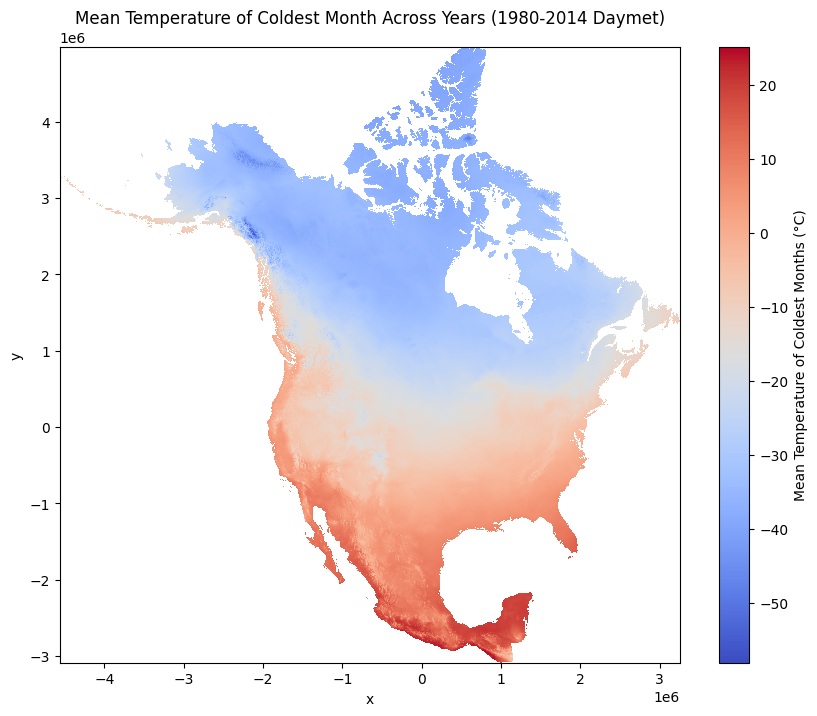

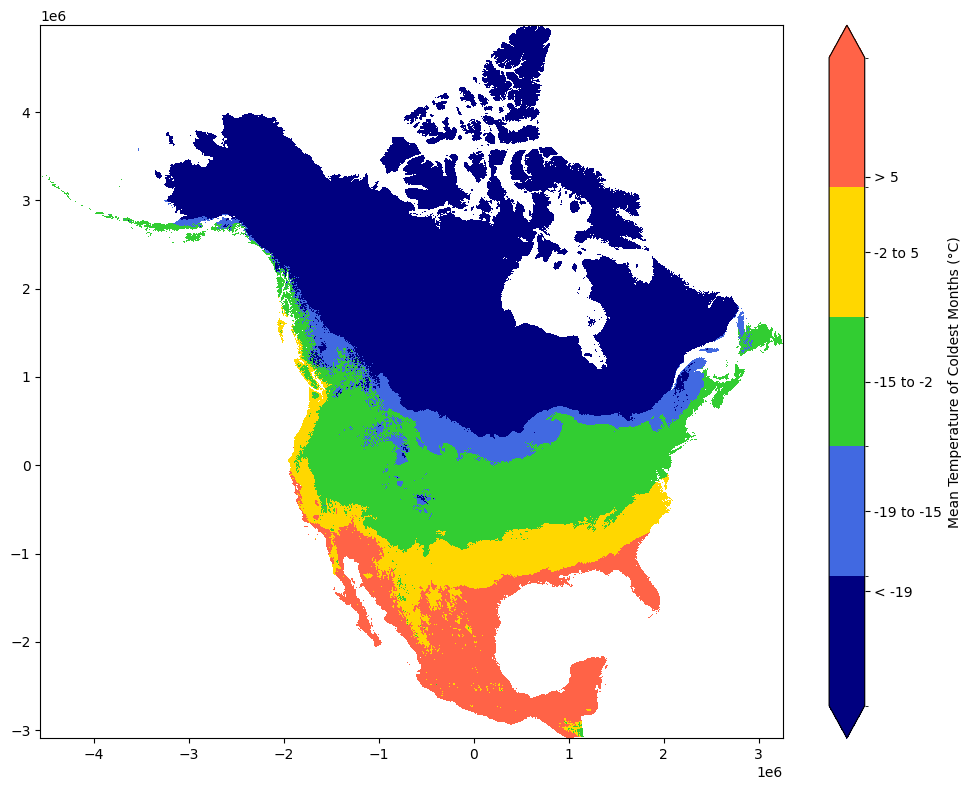

In [4]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

# Open the NetCDF file
filename = "mean_temperature_coldest_month.nc"
ds = nc.Dataset(filename)

# Read variables
x = ds.variables['x'][:]
y = ds.variables['y'][:]
lowest_temp = ds.variables['AvgTemp'][:]

# Mask NaN values if present
lowest_temp = np.ma.masked_invalid(lowest_temp)

plt.figure(figsize=(10, 8))
plt.pcolormesh(x, y, lowest_temp, shading='auto', cmap='coolwarm')
plt.colorbar(label='Mean Temperature of Coldest Months (°C)')
plt.title('Mean Temperature of Coldest Month Across Years (1980-2014 Daymet)')
plt.xlabel('x')
plt.ylabel('y')

# Add contour lines at -19, -15, -2, 5
#contour_levels = [-19, -15, -2, 5]
#X, Y = np.meshgrid(x, y)
#contours = plt.contour(X, Y, lowest_temp, levels=contour_levels, colors='k', linewidths=1.2)
#plt.clabel(contours, fmt='%d', colors='k')

# Define boundaries and colors for the regions
bounds = [-70, -19, -15, -2, 5, 30]
colors = ['navy', 'royalblue', 'limegreen', 'gold', 'tomato']
cmap = ListedColormap(colors)
norm = BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(10, 8))
mesh = plt.pcolormesh(x, y, lowest_temp, shading='auto', cmap=cmap, norm=norm)
cbar = plt.colorbar(mesh, boundaries=bounds, ticks=[-25, -17, -8.5, 1.5, 7], extend='both')
cbar.ax.set_yticklabels(['< -19', '-19 to -15', '-15 to -2', '-2 to 5', '> 5'])
cbar.set_label('Mean Temperature of Coldest Months (°C)')


plt.tight_layout()
plt.show()

ds.close()

tight_na_mask.nc:
  Rows with all NaN: 0
  Columns with all NaN: 0
  Total number of 1s: 21257202
Daymet_na_mask.nc:
  Rows with all NaN: 0
  Columns with all NaN: 0
  Total number of 1s: 21552672


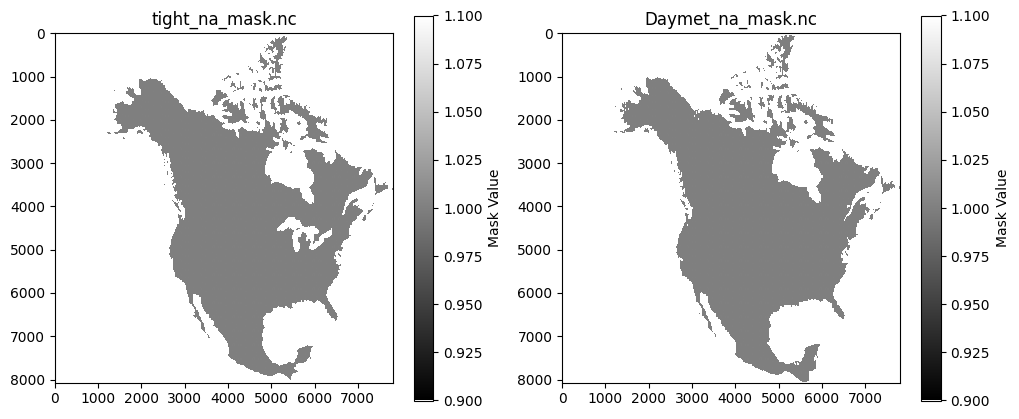

Unique values in mask1: (masked_array(data=[1.0, --],
             mask=[False,  True],
       fill_value=0.0), array([21257202, 41840848]))
Unique values in mask2: (masked_array(data=[1.0, --],
             mask=[False,  True],
       fill_value=0.0), array([21552672, 41545378]))
Number of NaNs in mask1: 0
Number of NaNs in mask2: 0
Unique values in diff_mask and their counts:
Value: 0.0, Count: 61149224
Value: 1.0, Count: 826678
Value: 2.0, Count: 1122148


/var/folders/5_/ckbw32j17xdch7y61tb8fnf80000gp/T/ipykernel_23746/1939639157.py:86: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


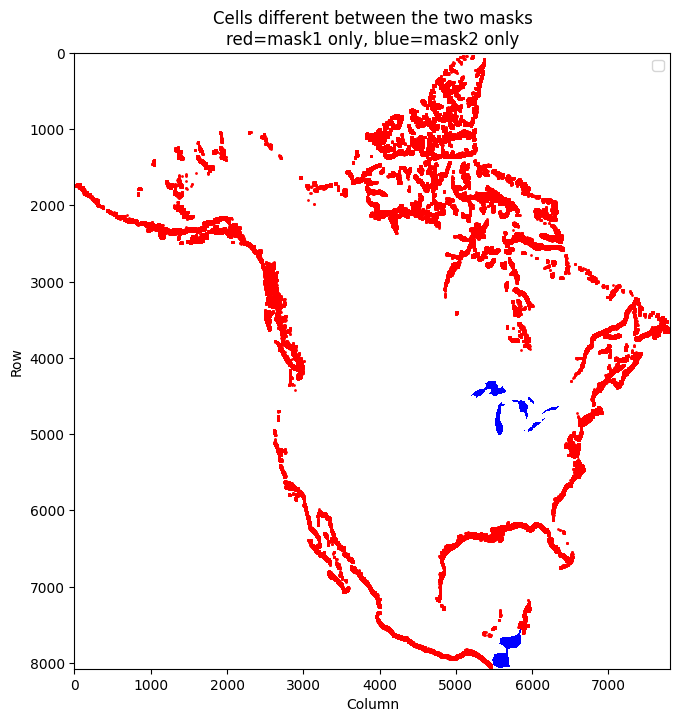

In [ ]:
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np

def mask_stats(mask, name):
    # Count rows and columns that are all NaN
    nan_rows = np.all(np.isnan(mask), axis=1).sum()
    nan_cols = np.all(np.isnan(mask), axis=0).sum()
    # Count total number of 1s
    ones_count = np.nansum(mask == 1)
    print(f"{name}:")
    print(f"  Rows with all NaN: {nan_rows}")
    print(f"  Columns with all NaN: {nan_cols}")
    print(f"  Total number of 1s: {ones_count}")

# Open the NetCDF files
with Dataset('tight_na_mask.nc') as nc1, Dataset('daymet_na_mask.nc') as nc2:
    mask1 = nc1.variables['na_mask'][:].astype(float)
    mask2 = nc2.variables['na_mask'][:].astype(float)

mask_stats(mask1, "tight_na_mask.nc")
mask_stats(mask2, "Daymet_na_mask.nc")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(mask1, cmap='gray')
plt.title('tight_na_mask.nc')
plt.colorbar(label='Mask Value')
plt.subplot(1, 2, 2)
plt.imshow(mask2, cmap='gray')
plt.title('Daymet_na_mask.nc')
plt.colorbar(label='Mask Value')
plt.show()


# Create a difference mask:
# 0: same in both
# 1: in mask1 only
# 2: in mask2 only
diff_mask = np.zeros_like(mask1)
diff_mask[(mask1 == 1) & (mask2 != 1)] = 1
diff_mask[(mask2 == 1) & (mask1 != 1)] = 2

# Save the difference mask to a NetCDF file
'''from netCDF4 import Dataset
with Dataset('mask_difference.nc', 'w', format='NETCDF4') as nc:
    nc.createDimension('y', diff_mask.shape[0])
    nc.createDimension('x', diff_mask.shape[1])
    diff_var = nc.createVariable('mask_diff', 'i1', ('y', 'x'), fill_value=0)
    diff_var[:, :] = diff_mask
    diff_var.long_name = 'Mask difference: 1=in mask1 only, 2=in mask2 only, 0=same'
    nc.description = 'Difference between tight_na_mask.nc and Daymet_na_mask.nc'
    '''


# Print unique values and NaN counts for both masks
print("Unique values in mask1:", np.unique(mask1, return_counts=True))
print("Unique values in mask2:", np.unique(mask2, return_counts=True))
print("Number of NaNs in mask1:", np.isnan(mask1).sum())
print("Number of NaNs in mask2:", np.isnan(mask2).sum())

# Convert masked arrays to normal arrays, filling masked values with 0
mask1_filled = mask1.filled(0)
mask2_filled = mask2.filled(0)

diff_mask = np.zeros_like(mask1_filled)
diff_mask[(mask1_filled == 1) & (mask2_filled != 1)] = 1  # in mask1 only
diff_mask[(mask2_filled == 1) & (mask1_filled != 1)] = 2  # in mask2 only

# Print unique values and counts for diff_mask
unique_diff_mask, counts_diff_mask = np.unique(diff_mask, return_counts=True)
print("Unique values in diff_mask and their counts:")
for value, count in zip(unique_diff_mask, counts_diff_mask):
    print(f"Value: {value}, Count: {count}")

plt.figure(figsize=(8, 8))
# Show the imshow for both mask1 and mask2 only
plt.imshow(masked - 1, cmap=cmap, vmin=0, vmax=1, origin='lower')
# Overlay the scatter plot for mask1 only
plt.scatter(indices[:,1], indices[:,0], s=1, color='red')
plt.gca().invert_yaxis()
plt.title('Cells different between the two masks\nred=mask1 only, blue=mask2 only')
plt.xlabel('Column')
plt.ylabel('Row')
#plt.colorbar(ticks=[0, 1], label='0=mask1 only, 1=mask2 only')
plt.legend(loc='upper right')
plt.show()

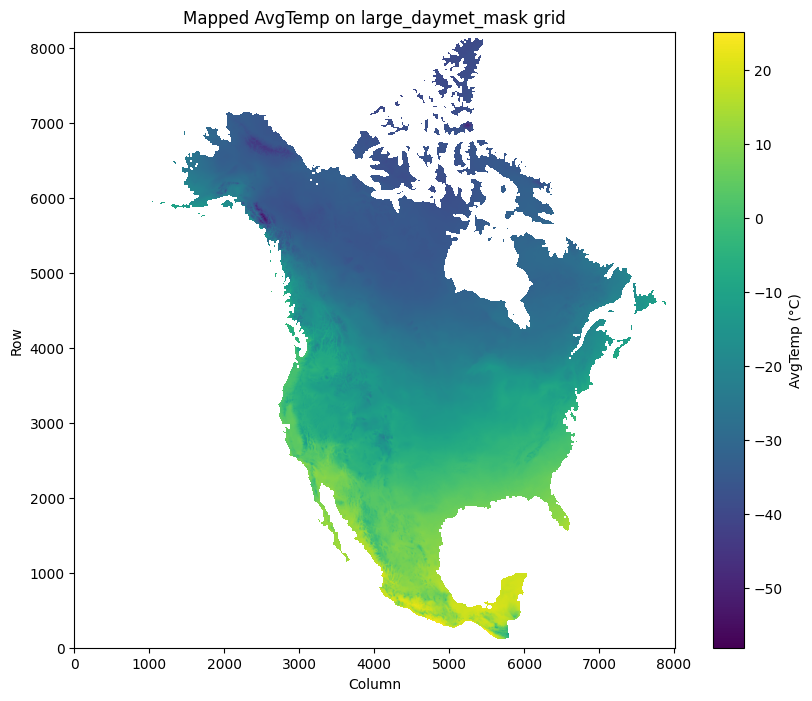

In [6]:
import numpy as np
from netCDF4 import Dataset
import rasterio

# Read AvgTemp from NetCDF
with Dataset('mean_temperature_coldest_month.nc') as nc:
    avgtemp = nc.variables['AvgTemp'][:]

# Read the mask from the GeoTIFF
with rasterio.open('large_daymet_mask.tif') as src:
    mask_data = src.read(1)
    out_shape = mask_data.shape

# Prepare an output array (same shape as mask, fill with np.nan)
mapped_temp = np.full(out_shape, np.nan, dtype=avgtemp.dtype)

# Place avgtemp into mapped_temp with the given offset
row_offset, col_offset = 101, 98
rows, cols = avgtemp.shape

mapped_temp[row_offset:row_offset+rows, col_offset:col_offset+cols] = avgtemp

# Now mapped_temp has AvgTemp in the correct location, rest is np.nan
# Example: Save as a new GeoTIFF (optional)
with rasterio.open(
    'mapped_avgtemp.tif', 'w',
    driver='GTiff',
    height=out_shape[0], width=out_shape[1],
        count=1, dtype=mapped_temp.dtype,
        crs=src.crs, transform=src.transform
) as dst:
    dst.write(mapped_temp, 1)

plt.figure(figsize=(10, 8))
plt.imshow(mapped_temp, origin='lower')
plt.title('Mapped AvgTemp on large_daymet_mask grid')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='AvgTemp (°C)')
plt.show()

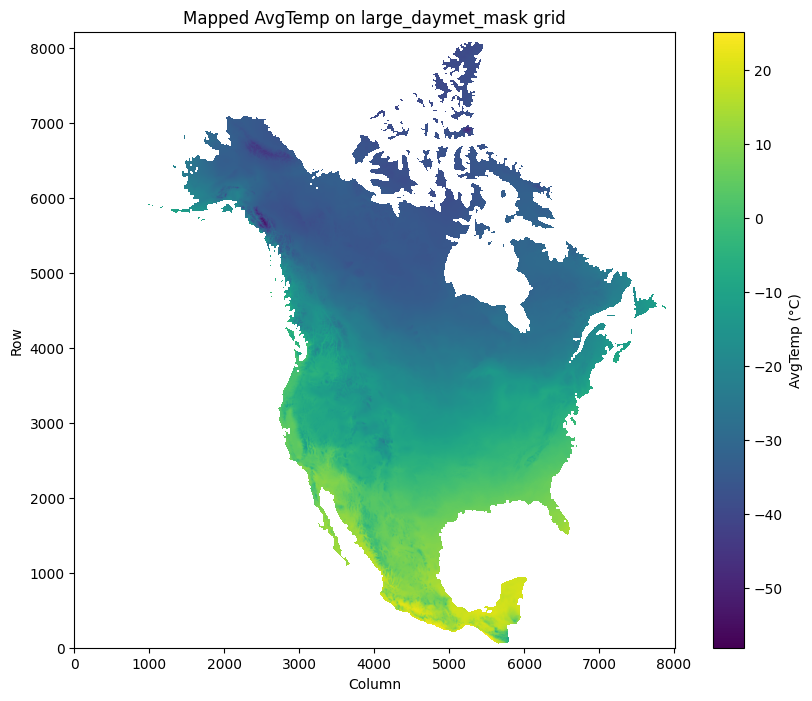

In [65]:
plt.figure(figsize=(10, 8))
plt.imshow(mapped_temp, origin='lower')
plt.title('Mapped AvgTemp on large_daymet_mask grid')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='AvgTemp (°C)')
plt.show()

In [56]:
import numpy as np
from netCDF4 import Dataset
import rasterio

# Read AvgTemp from NetCDF
with Dataset('mean_temperature_coldest_month.nc') as nc:
    avgtemp = nc.variables['AvgTemp'][:]

# Read the mask from the GeoTIFF
with rasterio.open('large_daymet_mask.tif') as src:
    mask_data = src.read(1)
    out_shape = mask_data.shape

# Prepare an output array (same shape as mask, fill with np.nan)
mapped_temp = np.full(out_shape, np.nan, dtype=avgtemp.dtype)

# Place avgtemp into mapped_temp with the given offset
row_offset, col_offset = 101, 98
rows, cols = avgtemp.shape
nrows = out_shape[0]

# Adjusted row offset for flipping
adjusted_row_offset = nrows - row_offset - rows

mapped_temp[adjusted_row_offset:adjusted_row_offset+rows, col_offset:col_offset+cols] = avgtemp

# Flip vertically before writing to GeoTIFF
mapped_temp_flipped = np.flipud(mapped_temp)

with rasterio.open(
    'mapped_avgtemp.tif', 'w',
    driver='GTiff',
    height=out_shape[0], width=out_shape[1],
    count=1, dtype=mapped_temp.dtype,
    crs=src.crs, transform=src.transform
) as dst:
    dst.write(mapped_temp_flipped, 1)

In [52]:
with rasterio.open('large_daymet_mask.tif') as src:
    mask_data = src.read(1)  # Read first band
    shape = mask_data.shape
    print("Shape of large_daymet_mask.tif:", shape)

    # Find all rows that have at least one mask==1
    rows_with_1 = np.where(np.any(mask_data == 1, axis=1))[0]
    if len(rows_with_1) > 0:
        top_row = rows_with_1[0]
        print("Top row with mask=1:", top_row)
    else:
        print("No row has mask=1")

Shape of large_daymet_mask.tif: (8220, 8011)
Top row with mask=1: 101


In [64]:

# Function to rewrite a NetCDF file with compression
def rewrite_with_compression(input_file, output_file):
    with Dataset(input_file, 'r') as src:
        # Create a new NetCDF file with compression
        with Dataset(output_file, 'w', format='NETCDF4') as dst:
            # Copy dimensions
            for name, dimension in src.dimensions.items():
                dst.createDimension(name, (len(dimension) if not dimension.isunlimited() else None))
            
            # Copy variables with compression
            for name, variable in src.variables.items():
                var_out = dst.createVariable(name, variable.datatype, variable.dimensions, zlib=True, complevel=5)
                var_out.setncatts({k: variable.getncattr(k) for k in variable.ncattrs()})
                var_out[:] = variable[:]
    
    print(f"Rewritten {input_file} to {output_file} with compression.")         

# Rewrite the NetCDF file with compression
rewrite_with_compression('tight_na_mask.nc', 'tight_na_mask_compressed.nc')
rewrite_with_compression('daymet_na_mask.nc', 'daymet_na_mask_compressed.nc')

# Open the compressed NetCDF file to verify

Rewritten tight_na_mask.nc to tight_na_mask_compressed.nc with compression.
Rewritten daymet_na_mask.nc to daymet_na_mask_compressed.nc with compression.


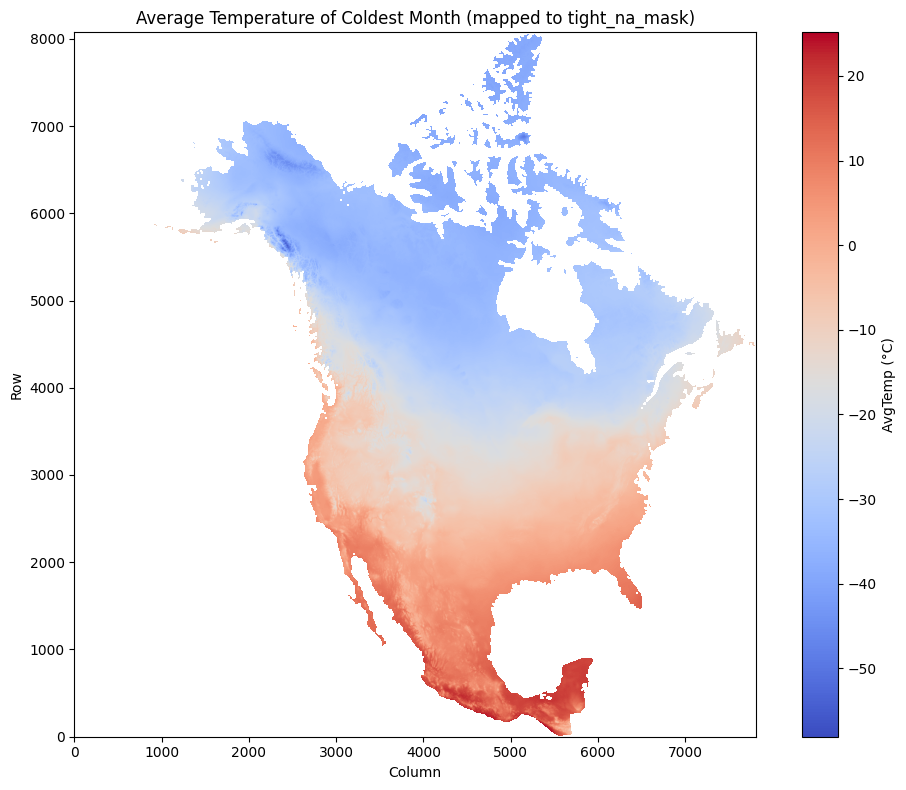

In [70]:
# Read the mapped temperature from NetCDF
with Dataset('avetemp_nalcms_mask.nc') as nc:
    avgtemp = nc.variables['AvgTemp'][:]

# Plot the data
plt.figure(figsize=(10, 8))
plt.imshow(avgtemp, origin='lower', cmap='coolwarm')
plt.colorbar(label='AvgTemp (°C)')
plt.title('Average Temperature of Coldest Month (mapped to tight_na_mask)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()

# Save to GeoTIFF using tight_na_mask.tif as reference
with rasterio.open('tight_na_mask.tif') as ref:
    profile = ref.profile
    profile.update(dtype='float32', count=1, nodata=np.nan)
    with rasterio.open('avetemp_nalcms_mask.tif', 'w', **profile) as dst:
        dst.write(avgtemp.astype('float32'), 1)

mask1 unique: [1 --]
total number of 1s in src_mask: 21552672
mask2 unique: [1 --]
total number of 1s in tgt_mask: 21257202
Mask comparison:
  Cells in src only: 1122148
  Cells in tgt only: 826678
  Cells in both: 20430524


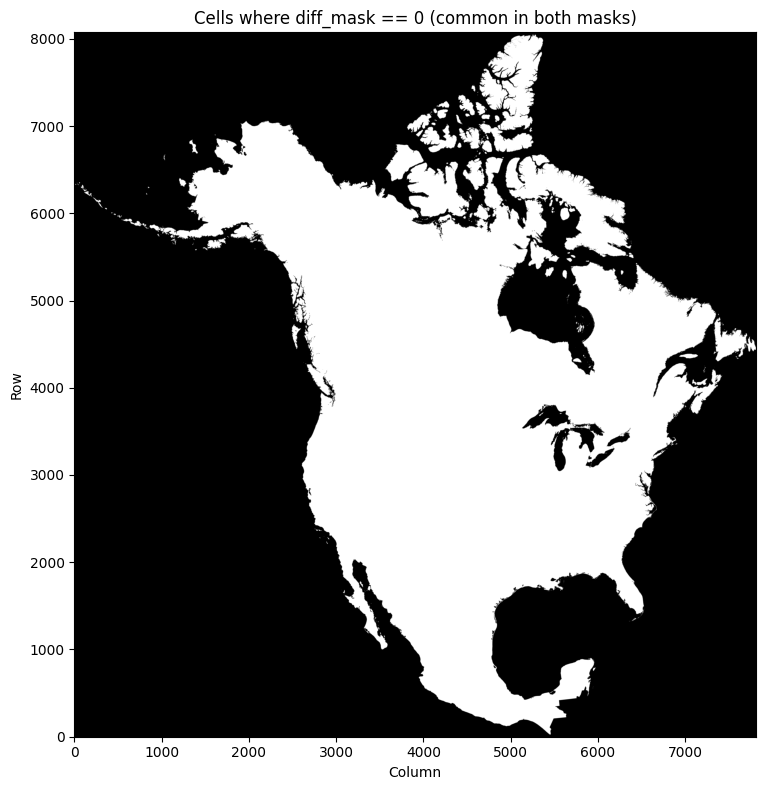

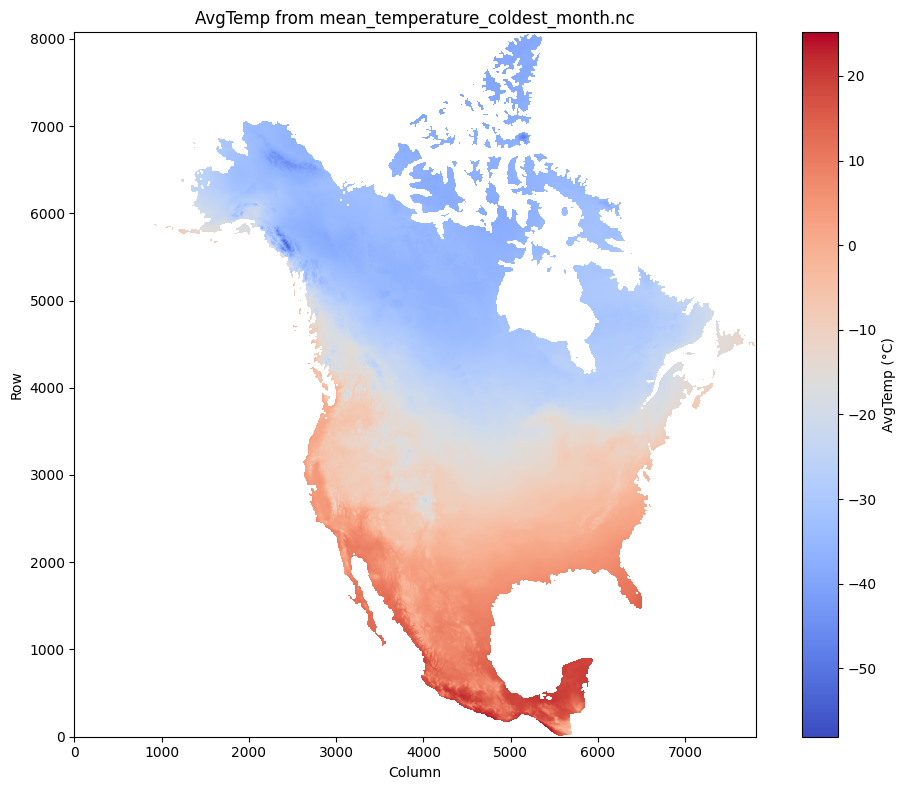

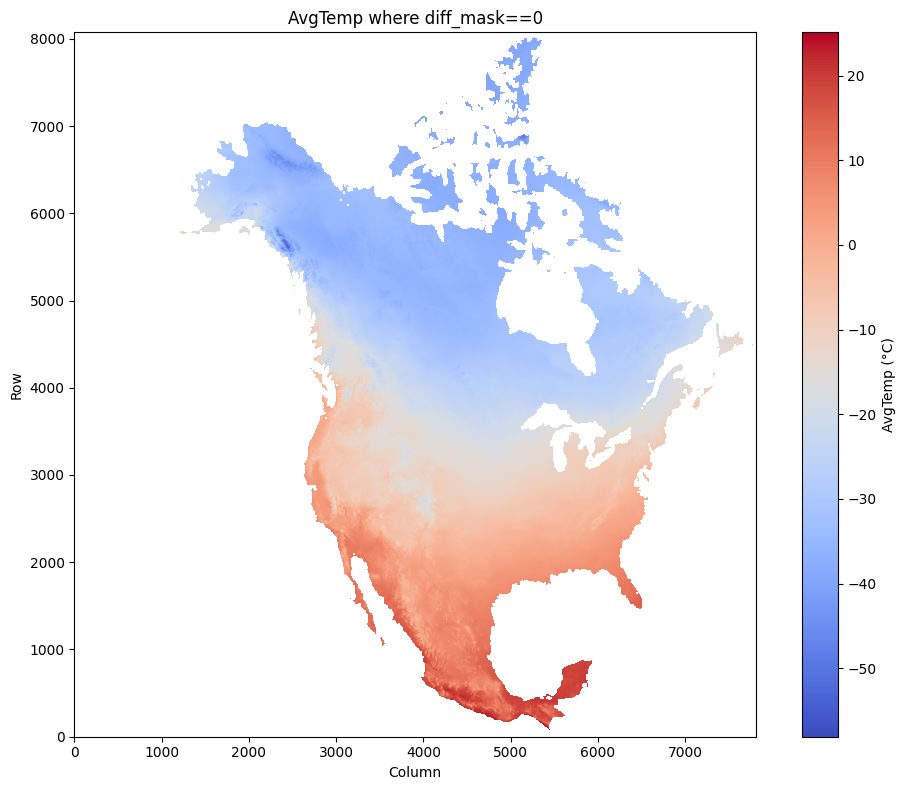

"\n# Save temp_valid as GeoTIFF using tight_na_mask.tif as reference (flip if needed)\nwith rasterio.open('tight_na_mask.tif') as ref:\n    profile = ref.profile\n    profile.update(dtype='float32', count=1, nodata=np.nan)\n    # Flip temp_valid vertically to match GeoTIFF orientation\n    temp_valid_flipped = np.flipud(temp_valid)\n    with rasterio.open('avetemp_nalcms_mask.tif', 'w', **profile) as dst:\n        dst.write(temp_valid_flipped.astype('float32'), 1)"

In [ ]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import rasterio

# Read source and target masks
with Dataset('daymet_na_mask_compressed.nc') as src_mask_nc, Dataset('tight_na_mask.nc') as tgt_mask_nc:
    src_mask = src_mask_nc.variables['na_mask'][:]
    tgt_mask = tgt_mask_nc.variables['na_mask'][:]

# Compare masks and print differences
print("mask1 unique:", np.unique(src_mask))
print("total number of 1s in src_mask:", np.sum(src_mask == 1))
print("mask2 unique:", np.unique(tgt_mask))
print("total number of 1s in tgt_mask:", np.sum(tgt_mask == 1))

diff_mask = np.zeros_like(tgt_mask, dtype=np.int8)
# Convert masked arrays to normal arrays, filling masked values with -1
mask1_filled = src_mask.filled(-1)
mask2_filled = tgt_mask.filled(-1)

diff_mask = np.zeros_like(mask1_filled) -1 
diff_mask[(mask1_filled == 1) & (mask2_filled == 1)] = 0  # in both mask1s
diff_mask[(mask1_filled == 1) & (mask2_filled != 1)] = 1  # in mask1 only
diff_mask[(mask2_filled == 1) & (mask1_filled != 1)] = 2  # in mask2 only

print("Mask comparison:")
print("  Cells in src only:", np.sum(diff_mask == 1))
print("  Cells in tgt only:", np.sum(diff_mask == 2))
print("  Cells in both:", np.sum((diff_mask == 0)))

# Plot the difference mask
plt.figure(figsize=(10, 8))
diff_mask=np.flipud(diff_mask)  # Flip vertically to match GeoTIFF orientation

plt.imshow((diff_mask == 0) | (diff_mask ==2), origin='lower', cmap='gray', vmin=0, vmax=1)
plt.title('Cells where diff_mask == 0 (common in both masks)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()

# Read temperature data
with Dataset('mean_temperature_coldest_month.nc') as temp_nc:
    temp = temp_nc.variables['AvgTemp'][:]

#plot temp data
plt.figure(figsize=(10, 8))
plt.imshow(temp, origin='lower', cmap='coolwarm')
plt.colorbar(label='AvgTemp (°C)')
plt.title('AvgTemp from mean_temperature_coldest_month.nc')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()      


# Mask temperature where diff_mask == 0
temp_valid = np.where((diff_mask == 0) | (diff_mask ==2), temp, np.nan)

# Plot temp_valid
plt.figure(figsize=(10, 8))
plt.imshow(temp_valid, origin='lower', cmap='coolwarm')
plt.colorbar(label='AvgTemp (°C)')
plt.title('AvgTemp where diff_mask==0')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()

# Save temp_valid as GeoTIFF using tight_na_mask.tif as reference (flip if needed)
with rasterio.open('tight_na_mask.tif') as ref:
    profile = ref.profile
    profile.update(dtype='float32', count=1, nodata=np.nan)
    # Flip temp_valid vertically to match GeoTIFF orientation
    temp_valid_flipped = np.flipud(temp_valid)
    with rasterio.open('avetemp_nalcms_mask.tif', 'w', **profile) as dst:
        dst.write(temp_valid_flipped.astype('float32'), 1)

mask1 unique: [1 --]
total number of 1s in mask1: 21257202
mask2 unique: [0 1]
total number of 1s in mask2: 21548628
Value: -1, Count: 41422608
Value: 0, Count: 21130388
Value: 1, Count: 126814
Value: 2, Count: 418240


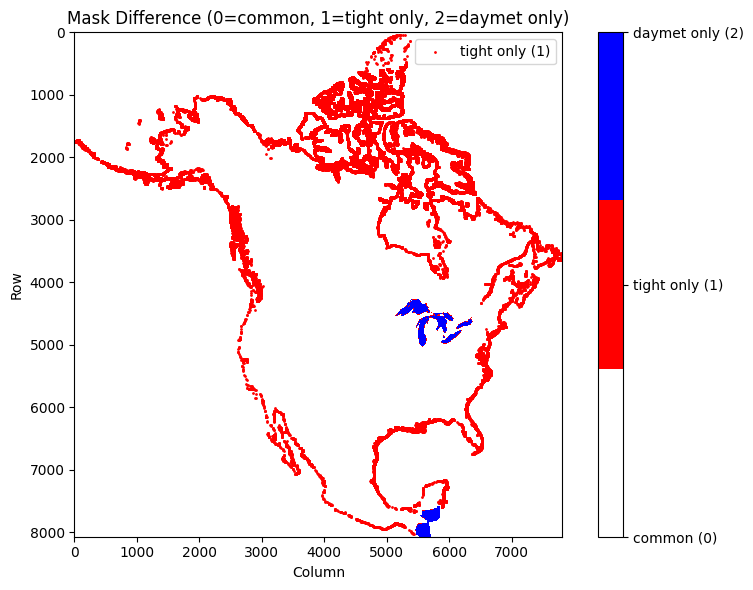

In [204]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

with Dataset('tight_na_mask.nc') as nc1, Dataset('daymet_na_mask_aligned.nc') as nc2:
    mask1 = nc1.variables['na_mask'][:].astype(int)
    mask2 = nc2.variables['na_mask'][:].astype(int)

print("mask1 unique:", np.unique(mask1))
print("total number of 1s in mask1:", np.sum(mask1 == 1))
print("mask2 unique:", np.unique(mask2))
print("total number of 1s in mask2:", np.sum(mask2 == 1))

# Convert masked arrays to normal arrays, filling masked values with 0
mask1_filled = mask1.filled(-1)
mask2_filled = mask2.filled(-1)

diff_mask = np.zeros_like(mask1_filled) - 1  # Initialize with -1

diff_mask[(mask1_filled == 1) & (mask2_filled == 1)] = 0  # in both masks
diff_mask[(mask1_filled == 1) & (mask2_filled != 1)] = 1  # in mask1 only
diff_mask[(mask2_filled == 1) & (mask1_filled != 1)] = 2  # in mask2 only

unique, counts = np.unique(diff_mask, return_counts=True)
for v, c in zip(unique, counts):
    print(f"Value: {v}, Count: {c}")

# Only plot values 0, 1, 2; mask -1 as transparent
plot_mask = np.ma.masked_where(diff_mask == -1, diff_mask)
cmap = ListedColormap(['white', 'red', 'blue'])  # 0=white, 1=red, 2=blue

plt.figure(figsize=(8, 6))
im = plt.imshow(plot_mask, cmap=cmap, vmin=0, vmax=2, origin='upper')

# Overlay red dots for all 1s (tight only)
indices = np.argwhere(diff_mask == 1)
plt.scatter(indices[:, 1], indices[:, 0], s=1, color='red', label='tight only (1)')

cbar = plt.colorbar(im, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['common (0)', 'tight only (1)', 'daymet only (2)'])
plt.title('Mask Difference (0=common, 1=tight only, 2=daymet only)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

mask1 unique: [1 --]
total number of 1s in mask1: 21257202
mask2 unique: [1 --]
total number of 1s in mask2: 21552672
Value: -1, Count: 40718700
Value: 0, Count: 20430524
Value: 1, Count: 826678
Value: 2, Count: 1122148


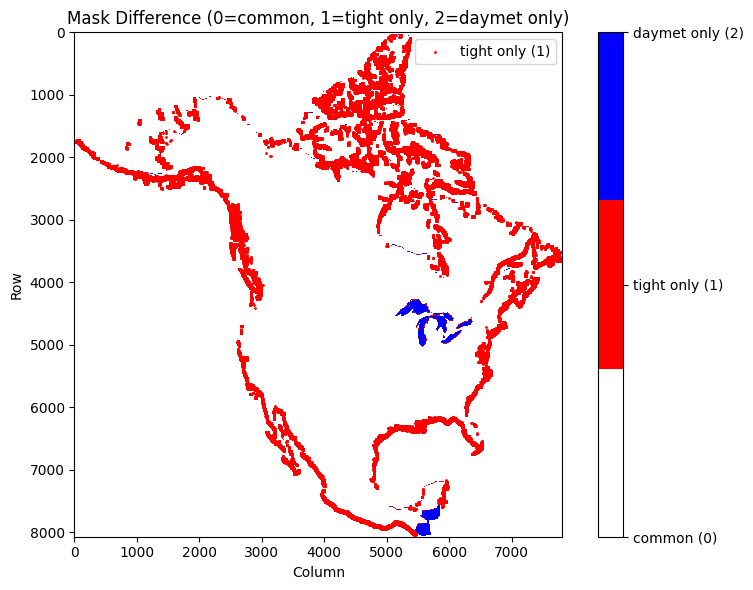

In [205]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

with Dataset('tight_na_mask.nc') as nc1, Dataset('daymet_na_mask.nc') as nc2:
    mask1 = nc1.variables['na_mask'][:].astype(int)
    mask2 = nc2.variables['na_mask'][:].astype(int)

print("mask1 unique:", np.unique(mask1))
print("total number of 1s in mask1:", np.sum(mask1 == 1))
print("mask2 unique:", np.unique(mask2))
print("total number of 1s in mask2:", np.sum(mask2 == 1))

# Convert masked arrays to normal arrays, filling masked values with 0
mask1_filled = mask1.filled(-1)
mask2_filled = mask2.filled(-1)

diff_mask = np.zeros_like(mask1_filled) - 1  # Initialize with -1

diff_mask[(mask1_filled == 1) & (mask2_filled == 1)] = 0  # in both masks
diff_mask[(mask1_filled == 1) & (mask2_filled != 1)] = 1  # in mask1 only
diff_mask[(mask2_filled == 1) & (mask1_filled != 1)] = 2  # in mask2 only

unique, counts = np.unique(diff_mask, return_counts=True)
for v, c in zip(unique, counts):
    print(f"Value: {v}, Count: {c}")

# Only plot values 0, 1, 2; mask -1 as transparent
plot_mask = np.ma.masked_where(diff_mask == -1, diff_mask)
cmap = ListedColormap(['white', 'red', 'blue'])  # 0=white, 1=red, 2=blue

plt.figure(figsize=(8, 6))
im = plt.imshow(plot_mask, cmap=cmap, vmin=0, vmax=2, origin='upper')

# Overlay red dots for all 1s (tight only)
indices = np.argwhere(diff_mask == 1)
plt.scatter(indices[:, 1], indices[:, 0], s=1, color='red', label='tight only (1)')

cbar = plt.colorbar(im, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['common (0)', 'tight only (1)', 'daymet only (2)'])
plt.title('Mask Difference (0=common, 1=tight only, 2=daymet only)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

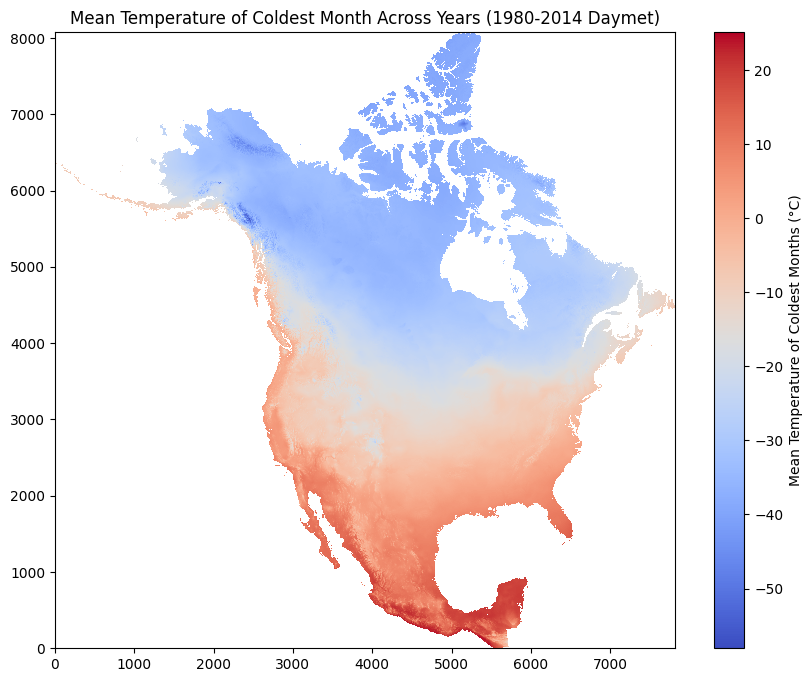

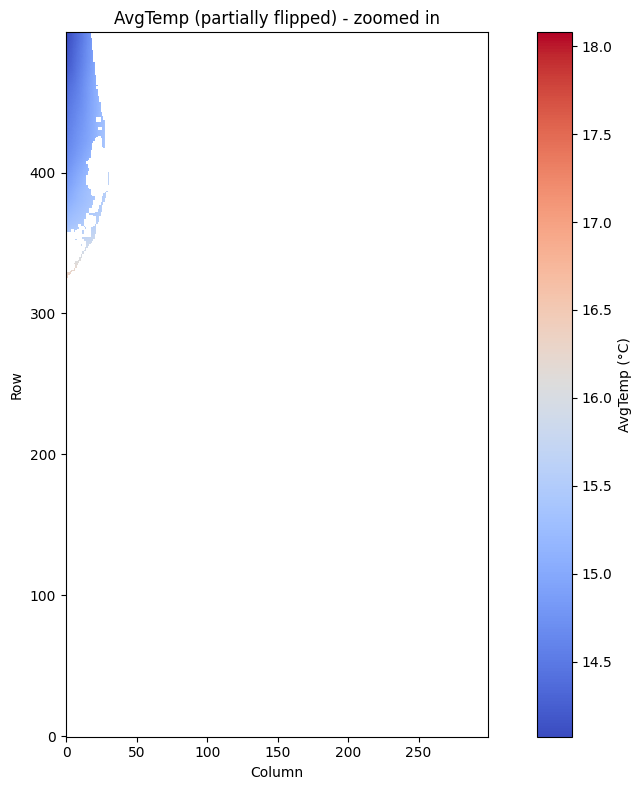

In [ ]:
# Open the NetCDF file
filename = "mean_temperature_coldest_month.nc"
ds = nc.Dataset(filename)

# Read variables
x = ds.variables['x'][:]
y = ds.variables['y'][:]
lowest_temp = ds.variables['AvgTemp'][:]

# Mask NaN values if present
lowest_temp = np.ma.masked_invalid(lowest_temp)

plt.figure(figsize=(10, 8))
plt.pcolormesh(lowest_temp, shading='auto', cmap='coolwarm')
plt.colorbar(label='Mean Temperature of Coldest Months (°C)')
plt.title('Mean Temperature of Coldest Month Across Years (1980-2014 Daymet)')

#plot a small part of the result
plt.figure(figsize=(10, 8))
plt.imshow(lowest_temp[1100:1600, 6500:7000], origin='lower', cmap='coolwarm')  
plt.colorbar(label='AvgTemp (°C)')
plt.title('AvgTemp (partially flipped) - zoomed in')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()

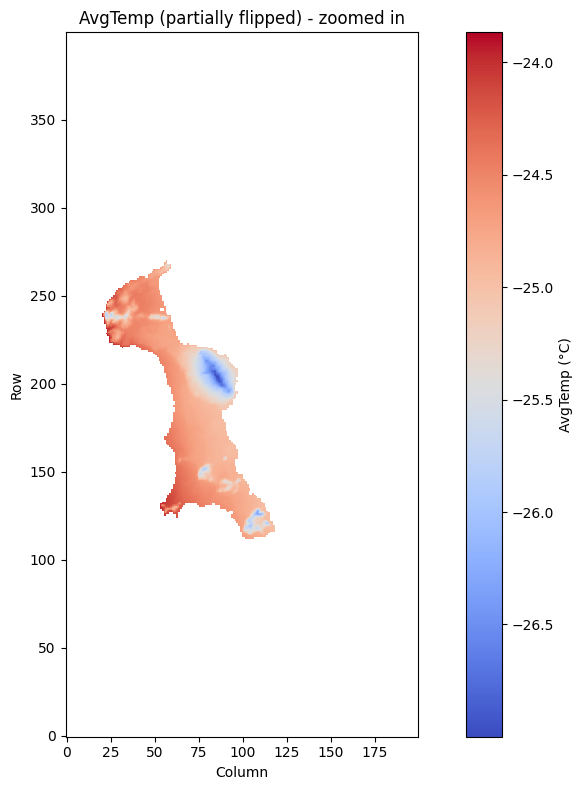

In [150]:
#plot a small part of the result
plt.figure(figsize=(10, 8))
plt.imshow(lowest_temp[6600:7000, 1300:1500], origin='lower', cmap='coolwarm')  
plt.colorbar(label='AvgTemp (°C)')
plt.title('AvgTemp (partially flipped) - zoomed in')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()

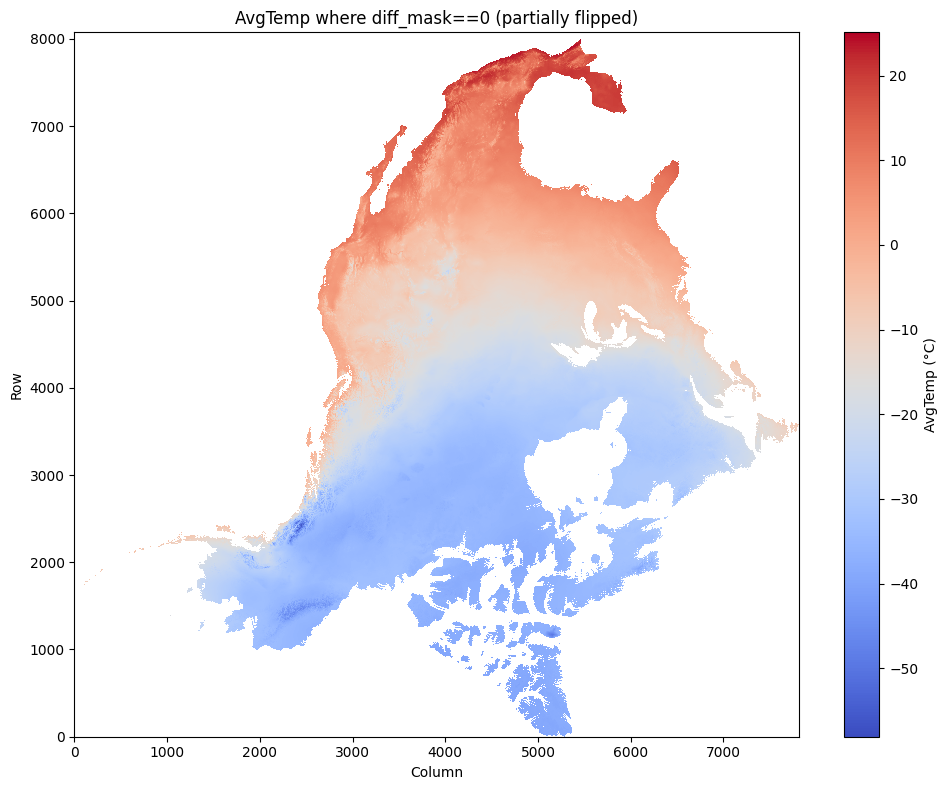

In [140]:
# Save temp_valid as GeoTIFF using tight_na_mask.tif as reference (flip if needed)

# Step 1: Flip vertically
flipped = np.flipud(temp_valid)

# Step 2: Find valid (not all-NaN) rows in the flipped array
valid_rows = ~np.all(np.isnan(flipped), axis=1)

# Step 3: Create a new array filled with NaN
result = np.full_like(temp_valid, np.nan)

# Step 4: Move valid rows to the top
num_valid = np.sum(valid_rows)
result[:num_valid, :] = flipped[valid_rows, :]

#plot the temp_valid_partially_flipped
plt.figure(figsize=(10, 8))
plt.pcolormesh(result, cmap='coolwarm')
plt.colorbar(label='AvgTemp (°C)')              
plt.title('AvgTemp where diff_mask==0 (partially flipped)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()

with rasterio.open('tight_na_mask.tif') as ref:
    profile = ref.profile
    profile.update(dtype='float32', count=1, nodata=np.nan)

    with rasterio.open('avetemp_nalcms_mask.tif', 'w', **profile) as dst:
        dst.write(result.astype('float32'), 1)

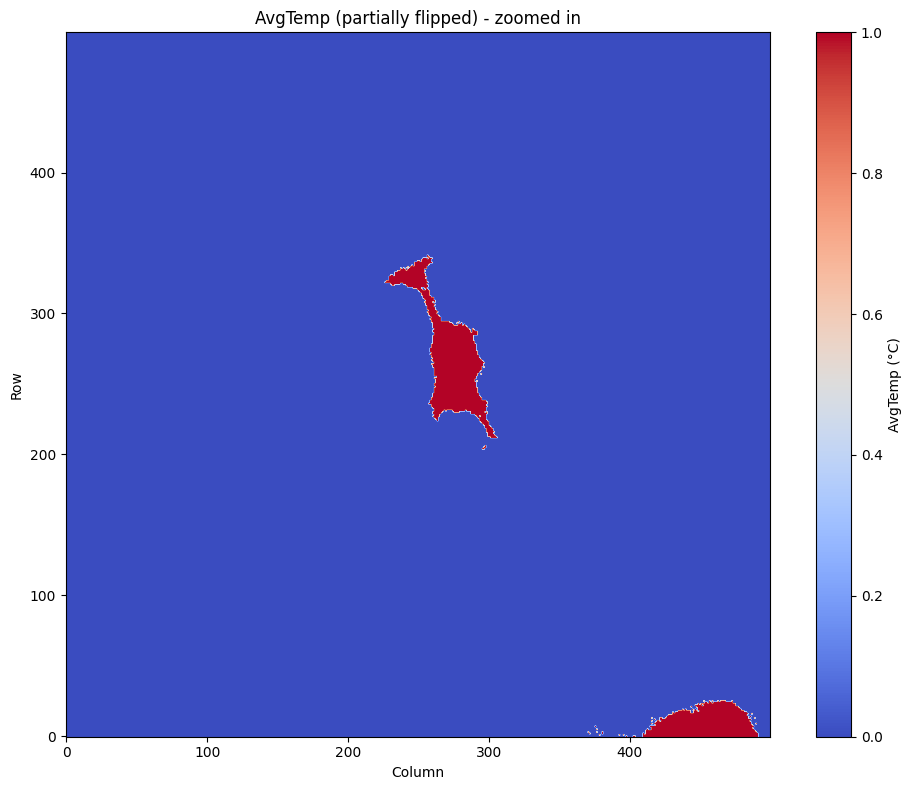

In [153]:
#plot a small part of the diff_mask

plt.figure(figsize=(10, 8))
plt.imshow(diff_mask[6500:7000,1100:1600]==0, origin='lower', cmap='coolwarm')  
plt.colorbar(label='AvgTemp (°C)')
plt.title('AvgTemp (partially flipped) - zoomed in')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()

In [139]:
#find out the number of naNs in the temperature data

# find the top row in avetemp_nalcms_mask.tif that has at least one cell with temperature data
with rasterio.open('avetemp_nalcms_mask.tif') as src:
    temp_data = src.read(1)
    rows_with_temp = np.where(~np.isnan(temp_data))[0]
    if len(rows_with_temp) > 0:
        top_row = rows_with_temp[0]
        print("Top row with temperature data:", top_row)
    else:
        print("No row has temperature data")

Top row with temperature data: 29


Shape of mask1 and mask2: (8075, 7814) (8075, 7814)
Shape of new_mask: (8075, 7814)
Value: 0, Count: 20133529
Value: 1, Count: 1123673
Value: --, Count: 41840848


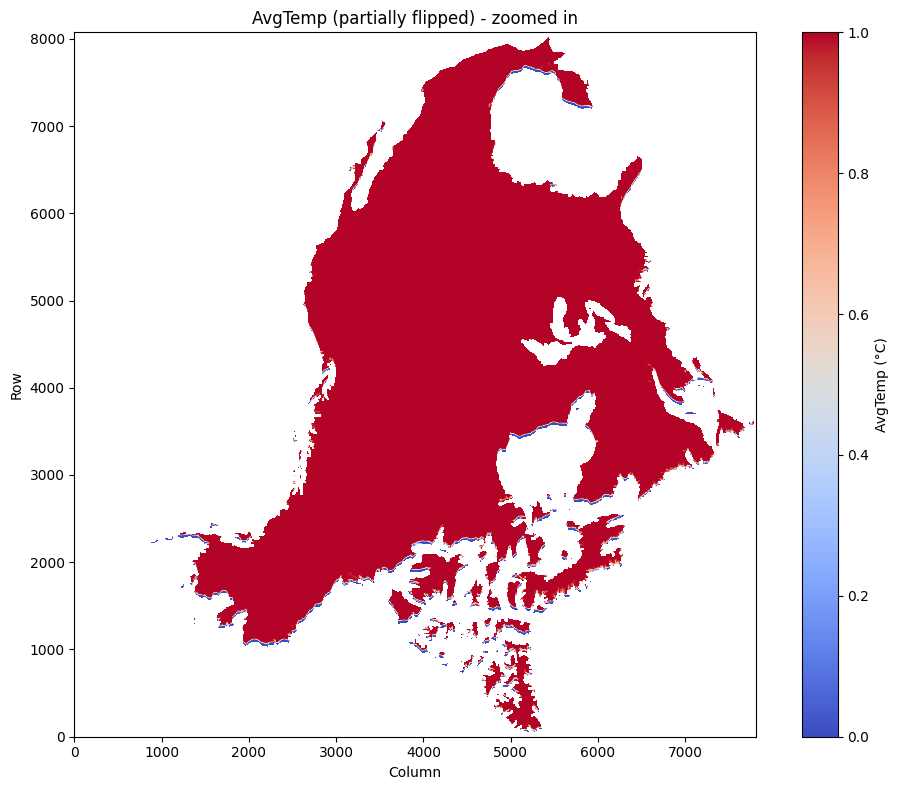

In [ ]:
# Read original tight_na_mask and daymet_na_mask
with Dataset('tight_na_mask.nc') as nc1, Dataset('daymet_na_mask.nc') as nc2:
    mask1 = nc1.variables['na_mask'][:].astype(int)
    mask2 = nc2.variables['na_mask'][:].astype(int)

print("Shape of mask1 and mask2:", mask1.shape, mask2.shape)

#print the shape of the new mask2
print("Shape of new_mask:", mask1.shape)

diff_mask = np.zeros_like(mask1, dtype=np.int8)
# Convert masked arrays to normal arrays, filling masked values with -1
mask1_filled = mask1.filled(-1)
mask2_filled = mask2.filled(-1)

# Step 1: Add 72 rows of -1 to the top and remove 10 rows from the bottom
row_shifted = 72
mask2_filled = np.vstack([
    -1 * np.ones((row_shifted, mask2.shape[1]), dtype=int),
    mask2[:-(row_shifted), :]
])

diff_mask[(mask2_filled == 1) & (mask1_filled == 1)] = 0  # in both mask
diff_mask[(mask1_filled == 1) & (mask2_filled != 1)] = 1  # in mask1 only
diff_mask[(mask2_filled == 1) & (mask1_filled != 1)] = 2  # in mask2 only

# Print summary
unique, counts = np.unique(diff_mask, return_counts=True)
for v, c in zip(unique, counts):
    print(f"Value: {v}, Count: {c}")

plt.figure(figsize=(10, 8))
#plt.imshow(diff_mask[6500:7000,1100:1600]==0, origin='lower', cmap='coolwarm')  
plt.imshow(diff_mask==0, origin='lower', cmap='coolwarm')  
plt.colorbar(label='AvgTemp (°C)')
plt.title('AvgTemp (partially flipped) - zoomed in')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()

In [1]:
# Read original tight_na_mask and daymet_na_mask
with Dataset('tight_na_mask.nc') as nc1, Dataset('daymet_na_mask_aligned.nc') as nc2:
    mask1 = nc1.variables['na_mask'][:].astype(int)
    mask2 = nc2.variables['na_mask'][:].astype(int)

print("Shape of mask1 and mask2:", mask1.shape, mask2.shape)

#print the shape of the new mask2
print("Shape of new_mask:", mask1.shape)

diff_mask = np.zeros_like(mask1, dtype=np.int8)
# Convert masked arrays to normal arrays, filling masked values with -1
mask1_filled = mask1.filled(-1)
mask2_filled = mask2.filled(-1)

diff_mask[(mask2_filled == 1) & (mask1_filled == 1)] = 0  # in both mask
diff_mask[(mask1_filled == 1) & (mask2_filled != 1)] = 1  # in mask1 only
diff_mask[(mask2_filled == 1) & (mask1_filled != 1)] = 2  # in mask2 only

# Print summary
unique, counts = np.unique(diff_mask, return_counts=True)
for v, c in zip(unique, counts):
    print(f"Value: {v}, Count: {c}")

plt.figure(figsize=(10, 8))
#plt.imshow(diff_mask[6500:7000,1100:1600]==0, origin='lower', cmap='coolwarm')  
plt.imshow(diff_mask==0, origin='lower', cmap='coolwarm')  
plt.colorbar(label='AvgTemp (°C)')
plt.title('AvgTemp (partially flipped) - zoomed in')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()

NameError: name 'Dataset' is not defined

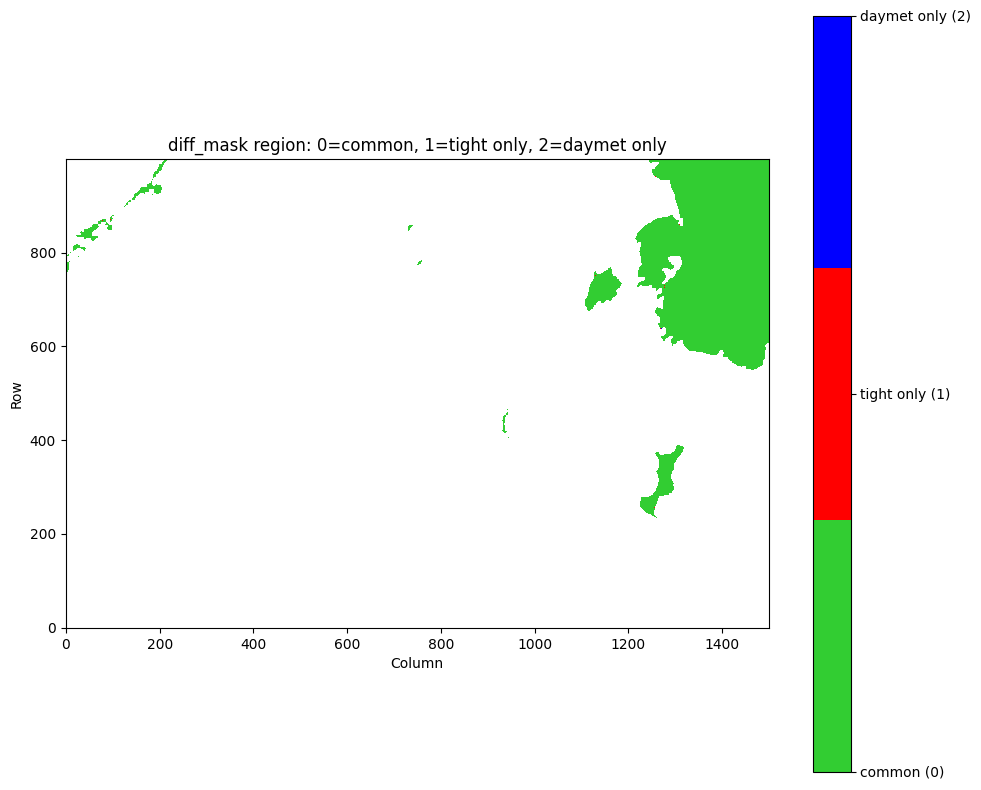

In [194]:
from matplotlib.colors import ListedColormap

region = diff_mask[1000:2000, 100:1600]

# Define a colormap: 0=green, 1=red, 2=blue
cmap = ListedColormap(['limegreen', 'red', 'blue'])
labels = {0: 'common (0)', 1: 'tight only (1)', 2: 'daymet only (2)'}

plt.figure(figsize=(10, 8))
im = plt.imshow(region, origin='lower', cmap=cmap, vmin=0, vmax=2)
cbar = plt.colorbar(im, ticks=[0, 1, 2])
cbar.ax.set_yticklabels([labels[0], labels[1], labels[2]])
plt.title('diff_mask region: 0=common, 1=tight only, 2=daymet only')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()

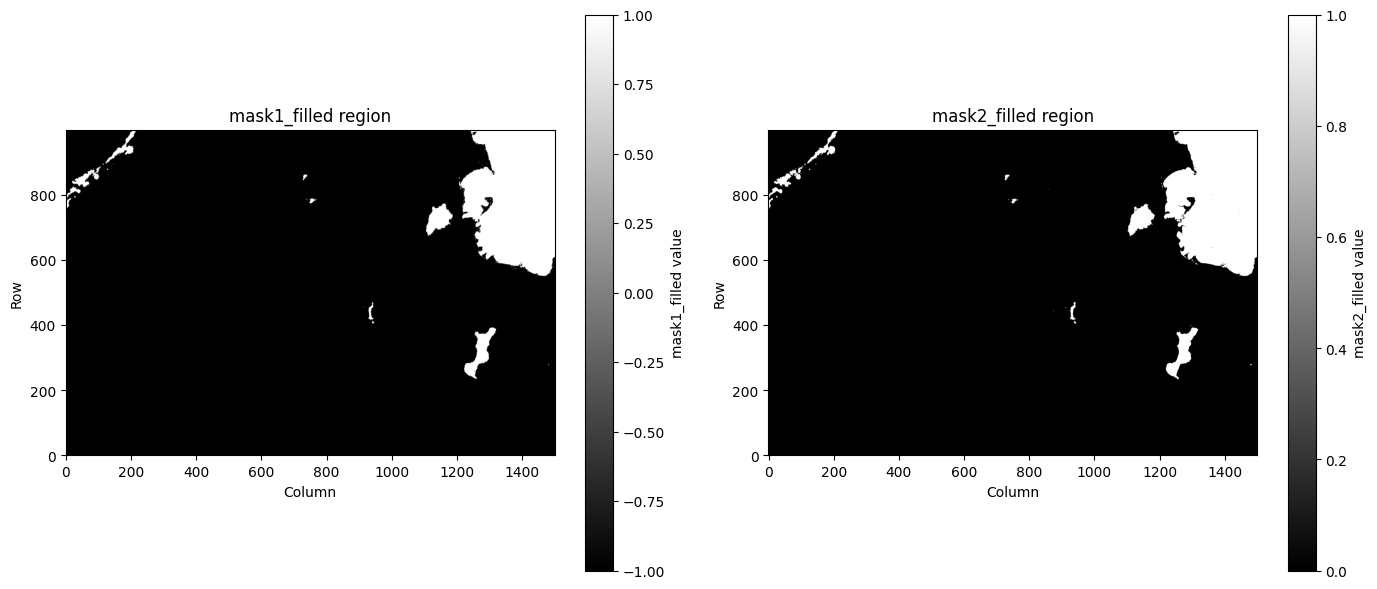

In [195]:
import matplotlib.pyplot as plt

region1 = mask1_filled[1000:2000, 100:1600]
region2 = mask2_filled[1000:2000, 100:1600]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(region1, origin='lower', cmap='gray')
plt.title('mask1_filled region')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='mask1_filled value')

plt.subplot(1, 2, 2)
plt.imshow(region2, origin='lower', cmap='gray')
plt.title('mask2_filled region')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='mask2_filled value')

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Row')

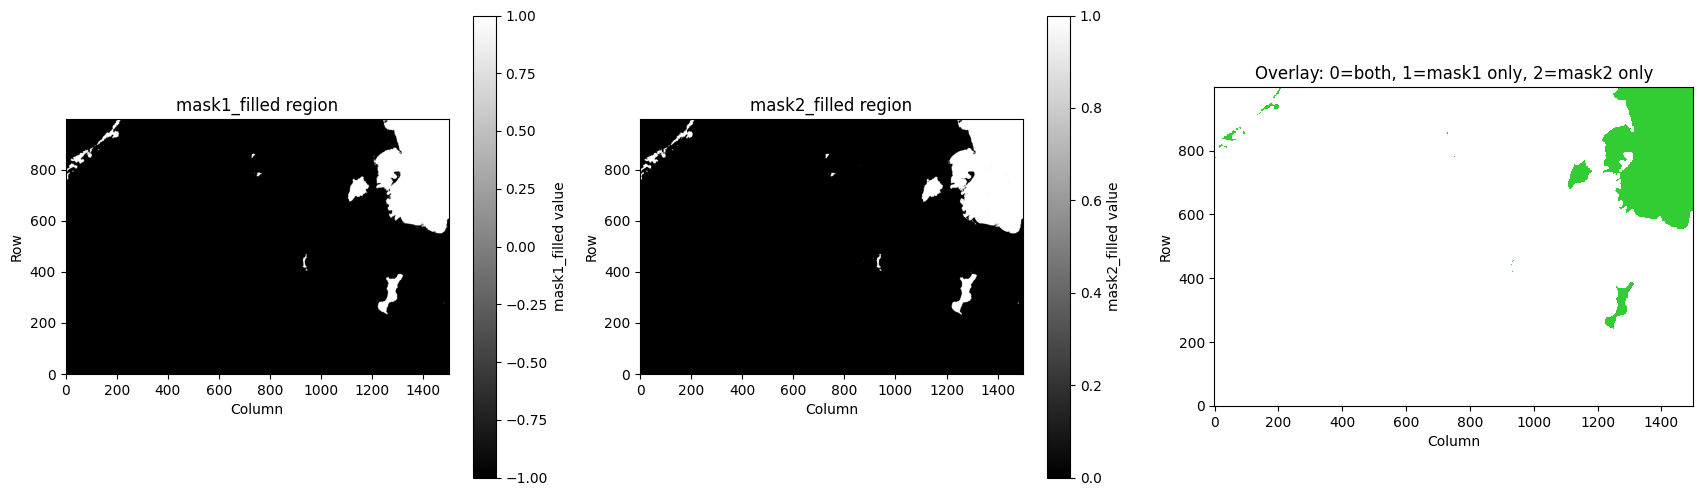

In [197]:
plt.figure(figsize=(21, 6))

# mask1_filled
plt.subplot(1, 3, 1)
plt.imshow(region1, origin='lower', cmap='gray')
plt.title('mask1_filled region')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='mask1_filled value')

# mask2_filled
plt.subplot(1, 3, 2)
plt.imshow(region2, origin='lower', cmap='gray')
plt.title('mask2_filled region')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='mask2_filled value')

# Overlay: 0=both 1, 1=mask1 only, 2=mask2 only
overlay = np.full(region1.shape, np.nan)
overlay[(region1 == 1) & (region2 == 1)] = 0
overlay[(region1 == 1) & (region2 != 1)] = 1
overlay[(region2 == 1) & (region1 != 1)] = 2
cmap_overlay = ListedColormap(['limegreen', 'red', 'blue'])
plt.subplot(1, 3, 3)
im = plt.imshow(overlay, origin='lower', cmap=cmap_overlay, vmin=0, vmax=2)
plt.title('Overlay: 0=both, 1=mask1 only, 2=mask2 only')
plt.xlabel('Column')
plt.ylabel('Row')

<Figure size 2100x600 with 0 Axes>

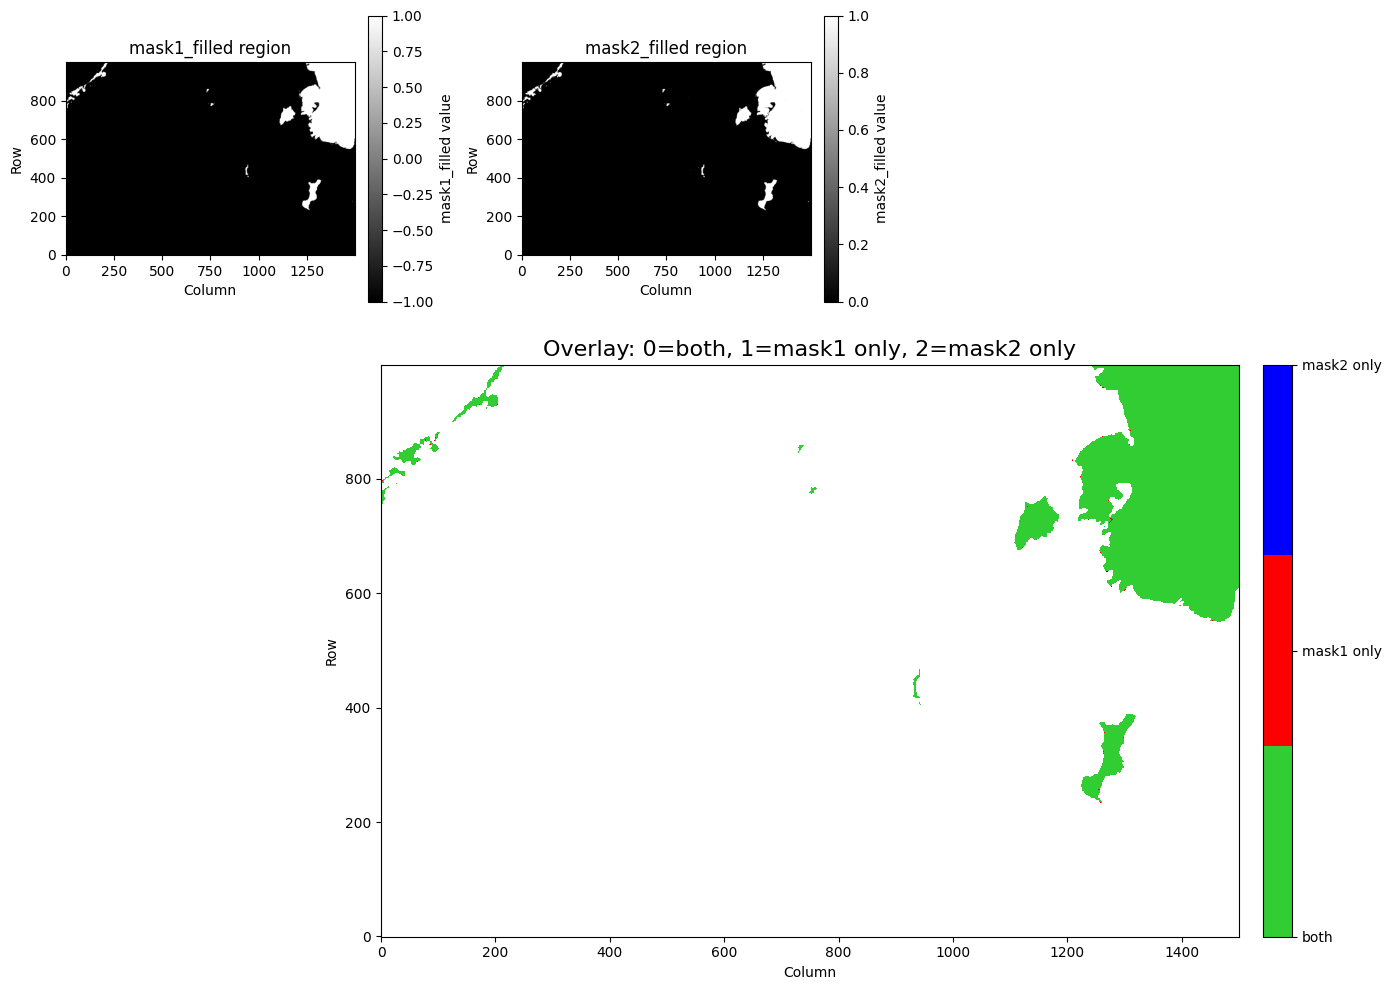

In [198]:
plt.figure(figsize=(21, 6))

# mask1_filled
plt.subplot(1, 3, 1)
plt.imshow(region1, origin='lower', cmap='gray')
plt.title('mask1_filled region')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='mask1_filled value')

# mask2_filled
plt.subplot(1, 3, 2)
plt.imshow(region2, origin='lower', cmap='gray')
plt.title('mask2_filled region')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='mask2_filled value')

# Overlay: 0=both 1, 1=mask1 only, 2=mask2 only
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec

plt.clf()
fig = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(2, 3, height_ratios=[1, 2])

# mask1_filled
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(region1, origin='lower', cmap='gray')
ax1.set_title('mask1_filled region')
ax1.set_xlabel('Column')
ax1.set_ylabel('Row')
fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label='mask1_filled value')

# mask2_filled
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(region2, origin='lower', cmap='gray')
ax2.set_title('mask2_filled region')
ax2.set_xlabel('Column')
ax2.set_ylabel('Row')
fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04, label='mask2_filled value')

# Overlay (much bigger)
ax3 = fig.add_subplot(gs[1, :])
cmap_overlay = ListedColormap(['limegreen', 'red', 'blue'])
im3 = ax3.imshow(overlay, origin='lower', cmap=cmap_overlay, vmin=0, vmax=2)
ax3.set_title('Overlay: 0=both, 1=mask1 only, 2=mask2 only', fontsize=16)
ax3.set_xlabel('Column')
ax3.set_ylabel('Row')
cbar = fig.colorbar(im3, ax=ax3, orientation='vertical', fraction=0.025, pad=0.02, ticks=[0, 1, 2])
cbar.ax.set_yticklabels(['both', 'mask1 only', 'mask2 only'])

plt.tight_layout()
plt.show()

In [7]:
import numpy as np
from netCDF4 import Dataset

# Load masks
with Dataset('tight_na_mask.nc') as nc1, Dataset('daymet_na_mask.nc') as nc2:
    mask1 = nc1.variables['na_mask'][:].astype(int)
    mask2 = nc2.variables['na_mask'][:].astype(int)

# Fill masked values with 0 for comparison
mask1_filled = np.ma.filled(mask1, 0)
mask2_filled = np.ma.filled(mask2, 0)

# Find optimal row shift to maximize overlap
max_overlap = -1
best_shift = 0
search_range = 50  # Try shifts from -50 to +50 rows

for shift in range(-search_range, search_range + 1):
    if shift < 0:
        m1 = mask1_filled[-shift:, :]
        m2 = mask2_filled[:shift, :]
    elif shift > 0:
        m1 = mask1_filled[:-shift, :]
        m2 = mask2_filled[shift:, :]
    else:
        m1 = mask1_filled
        m2 = mask2_filled
    overlap = np.sum((m1 == 1) & (m2 == 1))
    if overlap > max_overlap:
        max_overlap = overlap
        best_shift = shift

print(f"Best row shift for alignment: {best_shift} (positive means shift mask2 down)")

# Apply the shift to mask2
if best_shift < 0:
    mask2_aligned = np.vstack([
        np.zeros((-best_shift, mask2_filled.shape[1]), dtype=mask2_filled.dtype),
        mask2_filled[:best_shift, :]
    ])
elif best_shift > 0:
    mask2_aligned = np.vstack([
        mask2_filled[best_shift:, :],
        np.zeros((best_shift, mask2_filled.shape[1]), dtype=mask2_filled.dtype)
    ])
else:
    mask2_aligned = mask2_filled.copy()

# Save the shifted mask2 as a new NetCDF file
with Dataset('daymet_na_mask_aligned.nc', 'w', format='NETCDF4') as nc:
    nc.createDimension('y', mask2_aligned.shape[0])
    nc.createDimension('x', mask2_aligned.shape[1])
    var = nc.createVariable('na_mask', 'i1', ('y', 'x'), zlib=True, complevel=5)
    var[:, :] = mask2_aligned
    var.long_name = f"daymet_na_mask shifted by {best_shift} rows for alignment with tight_na_mask"

print("Aligned mask saved as daymet_na_mask_aligned.nc")

Best row shift for alignment: -28 (positive means shift mask2 down)
Aligned mask saved as daymet_na_mask_aligned.nc


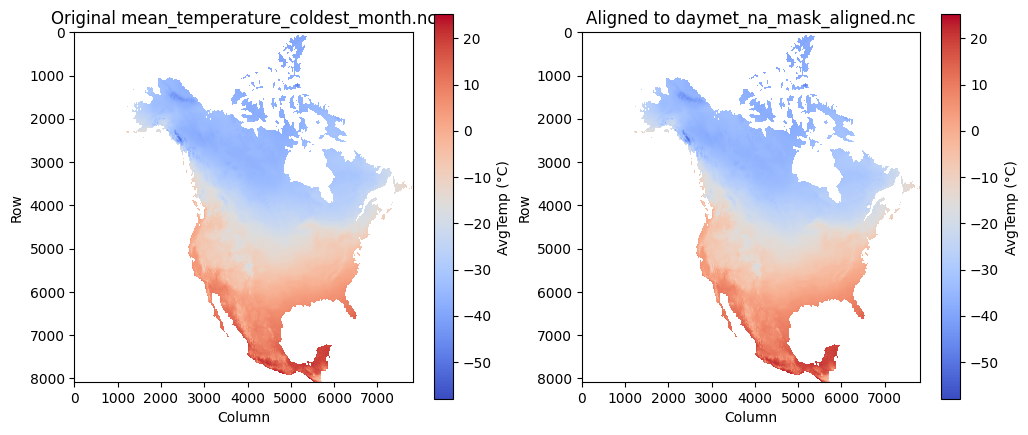

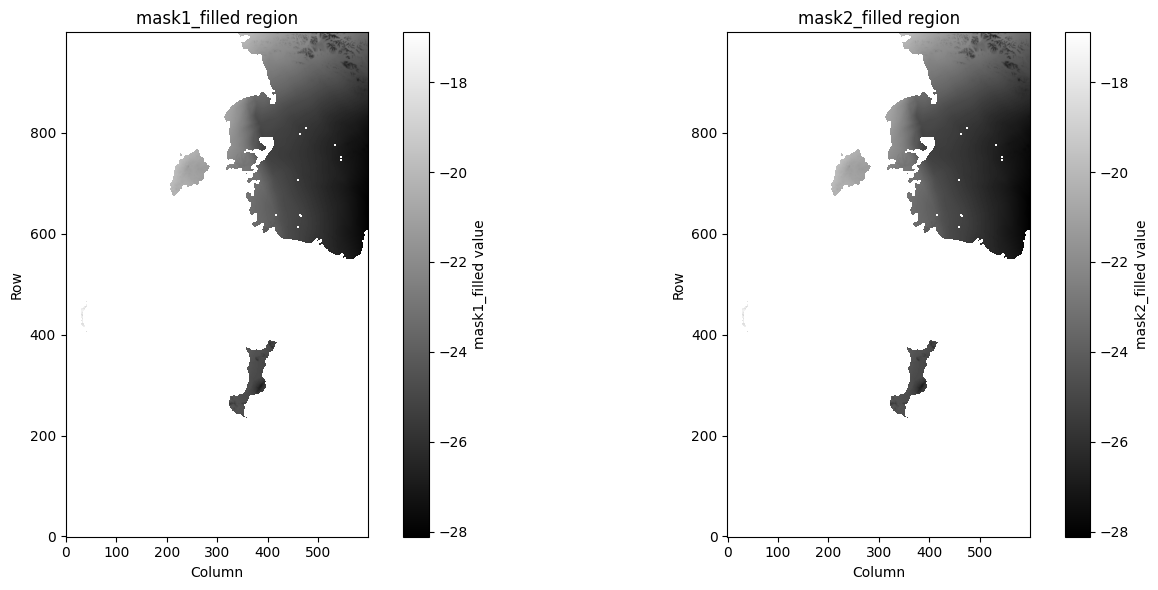

In [10]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt

# Open the original temperature file
with Dataset('mean_temperature_coldest_month.nc') as temp_nc:
    temp = temp_nc.variables['AvgTemp'][:]

# Open the aligned mask file
with Dataset('daymet_na_mask_aligned.nc') as mask_nc:
    mask = mask_nc.variables['na_mask'][:]

#these mean_temperature_codest_month.nc are upside down, so we need to flip
aligned_temp = np.flipud(temp)

# the two files have the same direction now 
# next we want to align the temperature data to the mask by using the result from the previous step
# Best row shift for alignment: -28 (positive means shift mask2 down)
# Apply the row shift to the aligned temperature data
row_shift = -28 
if row_shift < 0:
    aligned_temp = np.vstack([
        np.full((-row_shift, aligned_temp.shape[1]), np.nan, dtype=aligned_temp.dtype),
        aligned_temp[:row_shift, :]
    ])
elif row_shift > 0:
    aligned_temp = np.vstack([
        aligned_temp[row_shift:, :],
        np.full((row_shift, aligned_temp.shape[1]), np.nan, dtype=aligned_temp.dtype)
    ])  

# Mask out values where mask != 1
aligned_temp_masked = np.where(mask == 1, aligned_temp, np.nan)

# Plot original temperature
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(aligned_temp, origin='upper', cmap='coolwarm')
plt.title('Original mean_temperature_coldest_month.nc')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='AvgTemp (°C)')

# Plot aligned temperature
plt.subplot(1, 2, 2)
plt.imshow(aligned_temp_masked, origin='upper', cmap='coolwarm')
plt.title('Aligned to daymet_na_mask_aligned.nc')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='AvgTemp (°C)')


region1 = aligned_temp[1000:2000, 1000:1600]
region2 = aligned_temp_masked[1000:2000, 1000:1600]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(region1, origin='lower', cmap='gray')
plt.title('mask1_filled region')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='mask1_filled value')

plt.subplot(1, 2, 2)
plt.imshow(region2, origin='lower', cmap='gray')
plt.title('mask2_filled region')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='mask2_filled value')



plt.tight_layout()
plt.show()

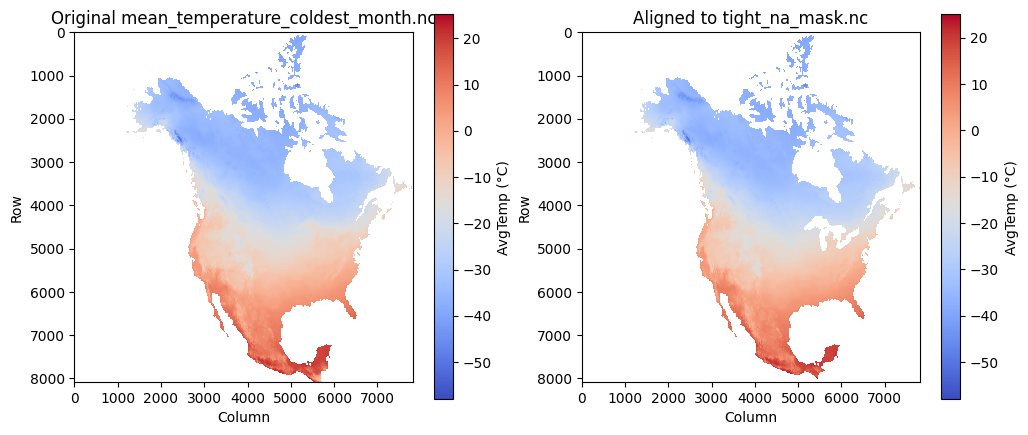

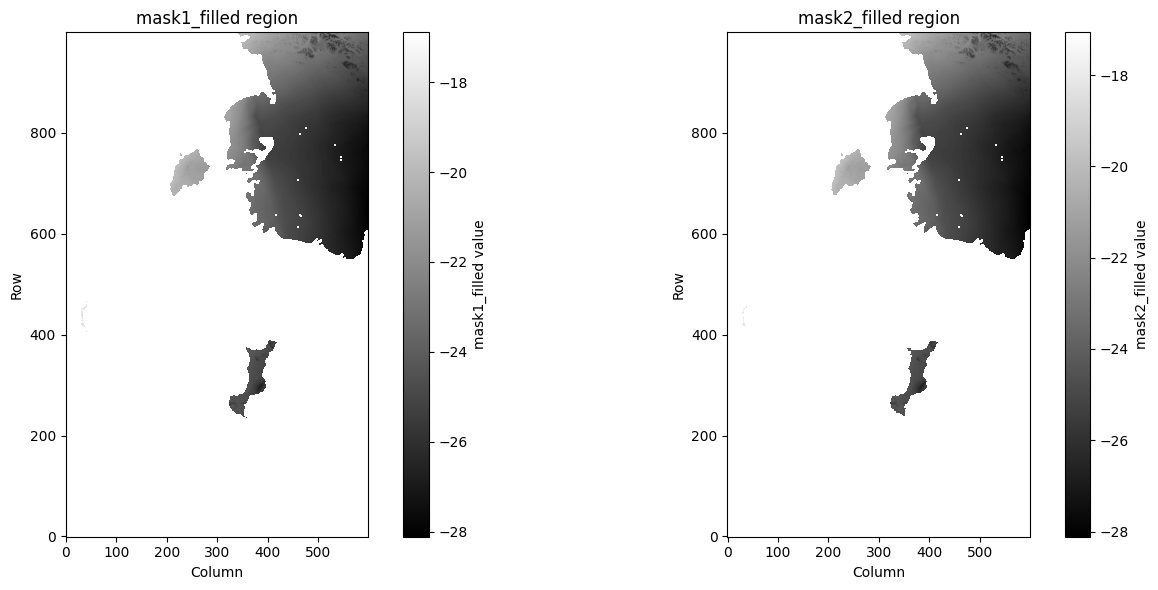

In [12]:
# read another mask file tight_na_mask.nc
with Dataset('tight_na_mask.nc') as nc:
    nalcms_mask = nc.variables['na_mask'][:].astype(int)      

# map the aligned temperature data to the tight_na_mask
# Find the bounding box of valid data in the aligned temperature
aligned_temp_nalcms_masked = np.where(nalcms_mask == 1, aligned_temp, np.nan)   

# Plot original temperature
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(aligned_temp, origin='upper', cmap='coolwarm')
plt.title('Original mean_temperature_coldest_month.nc')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='AvgTemp (°C)')

# Plot aligned temperature
plt.subplot(1, 2, 2)
plt.imshow(aligned_temp_nalcms_masked, origin='upper', cmap='coolwarm')
plt.title('Aligned to tight_na_mask.nc')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='AvgTemp (°C)')

region1 = aligned_temp[1000:2000, 1000:1600]
region2 = aligned_temp_nalcms_masked[1000:2000, 1000:1600]

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(region1, origin='lower', cmap='gray')
plt.title('mask1_filled region')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='mask1_filled value')

plt.subplot(1, 2, 2)
plt.imshow(region2, origin='lower', cmap='gray')
plt.title('mask2_filled region')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='mask2_filled value')

plt.tight_layout()
plt.show()


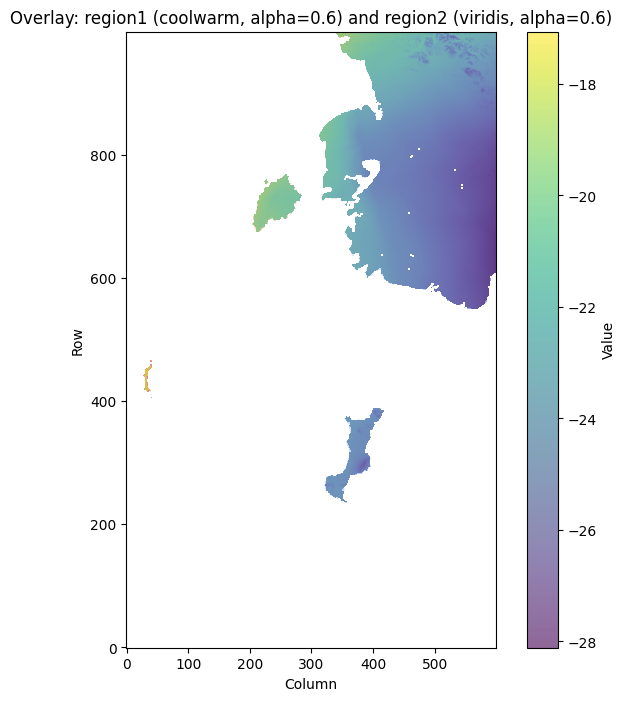

In [13]:
plt.figure(figsize=(8, 8))
plt.imshow(region1, origin='lower', cmap='coolwarm', alpha=0.6, label='region1')
plt.imshow(region2, origin='lower', cmap='viridis', alpha=0.6, label='region2')
plt.title('Overlay: region1 (coolwarm, alpha=0.6) and region2 (viridis, alpha=0.6)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.colorbar(label='Value')
plt.show()

In [14]:
#open the tight_na_mask.tif file and add the aligned_temp_nalcms_masked into it and save the result as a new tif file
import rasterio
from rasterio.transform import from_origin    

#undo_shift = 22
undo_shift = 22  # Adjust this value based on your alignment needs

if undo_shift > 0:
    aligned_temp_nalcms_masked_unshifted = np.vstack([
        aligned_temp_nalcms_masked[undo_shift:, :],
        np.full((undo_shift, aligned_temp_nalcms_masked.shape[1]), np.nan, dtype=aligned_temp_nalcms_masked.dtype)
    ])
else:
    aligned_temp_nalcms_masked_unshifted = aligned_temp_nalcms_masked.copy()

# Open the tight_na_mask.tif file to get its profile
with rasterio.open('tight_na_mask.tif') as src:
    profile = src.profile       
    profile.update(dtype='float32', count=1, nodata=np.nan)
    # Do NOT change height/width/transform if shape matches!
    # If aligned_temp_nalcms_masked.shape == src.shape, just use the original profile:
    with rasterio.open('avgtemp_nalcms_masked.tif', 'w', **profile) as dst:
        dst.write(aligned_temp_nalcms_masked_unshifted.astype('float32'), 1)  
print("Saved aligned temperature data as avgtemp_nalcms_masked.tif")  


Saved aligned temperature data as avgtemp_nalcms_masked.tif


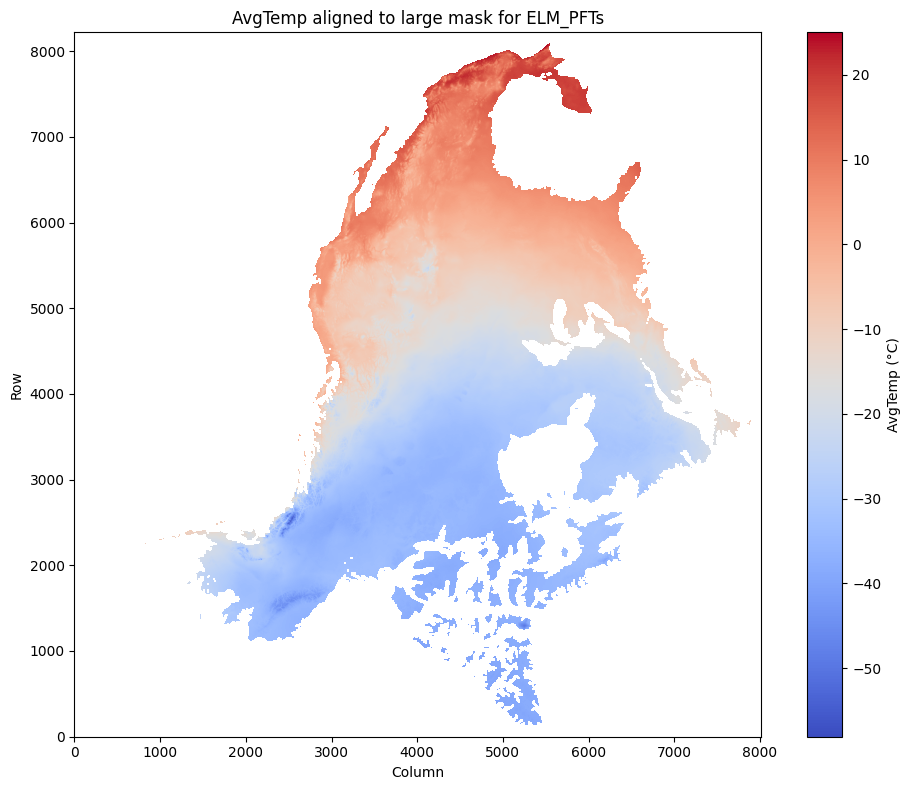

Saved as aligned_temp_to_large_nalcms_mask.nc


In [4]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt

# Load large mask (landtype1_nalcms_Temperate_needleleaf_in_daymet.nc)
with Dataset('landtype1_nalcms_Temperate_needleleaf_in_daymet.nc') as nc:
    count = nc.variables['landtype_count'][:]
    large_mask = np.where(np.isnan(count), 0, 1)

# Load temp_mask (from AvgTemp_nalcms_mask.nc or similar)
with Dataset('AvgTemp_nalcms_mask.nc') as nc:
    temp_data = nc.variables['AvgTemp'][:]
    temp_mask = np.where(~np.isnan(temp_data), 1, 0)

# Find bounding box of temp_mask
temp_y, temp_x = np.where(temp_mask == 1)
temp_min_y, temp_max_y = np.min(temp_y), np.max(temp_y)
temp_min_x, temp_max_x = np.min(temp_x), np.max(temp_x)

# Find bounding box of large_mask
large_y, large_x = np.where(large_mask == 1)
large_min_y, large_min_x = np.min(large_y), np.min(large_x)

# Calculate offset to align temp_mask in large_mask
offset_y = temp_min_y - large_min_y
offset_x = temp_min_x - large_min_x

# Optionally, apply row shift if needed (e.g., from previous alignment)

col_shift = 98  # Set this if you have a known shift

# Prepare output array (same shape as large_mask, fill with np.nan)
output = np.full(large_mask.shape, np.nan, dtype=temp_data.dtype)

# Place temp_data into output at the correct location
start_y = temp_min_y - offset_y
start_x = temp_min_x - offset_x
end_y = start_y + temp_data.shape[0]
end_x = start_x + temp_data.shape[1]

output[start_y:end_y, start_x:end_x] = temp_data

# we need to shift the output to align with the large_mask
row_shift = 29  # Set this if you have a known shift
if row_shift < 0:
    output = np.vstack([
        np.full((-row_shift, output.shape[1]), np.nan, dtype=output.dtype),
        output[:row_shift, :]
    ])
elif row_shift > 0:
    output = np.vstack([
        output[row_shift:, :],
        np.full((row_shift, output.shape[1]), np.nan, dtype=output.dtype)
    ])          

# Plot the output to verify alignment
plt.figure(figsize=(10, 8)) 
plt.imshow(output, origin='lower', cmap='coolwarm')
plt.colorbar(label='AvgTemp (°C)')
plt.title('AvgTemp aligned to large mask for ELM_PFTs')
plt.xlabel('Column')    
plt.ylabel('Row')
plt.tight_layout()
plt.show()


# Save to NetCDF with the same shape as large_mask
with Dataset('aligned_temp_to_large_nalcms_mask.nc', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', large_mask.shape[0])
    dst.createDimension('x', large_mask.shape[1])
    temp_var = dst.createVariable('AvgTemp', 'f4', ('y', 'x'), fill_value=np.nan, zlib=True, complevel=5)
    temp_var[:, :] = output
    temp_var.long_name = "AvgTemp aligned to large mask for ELM_PFTs"
    temp_var.units = "C"
print("Saved as aligned_temp_to_large_nalcms_mask.nc")

Unique values in diff_mask: [-1  0  1]
Value: 0, Count: 21130388  (common )
Value: 1, Count: 126814 (in large mask not in temp_mask)


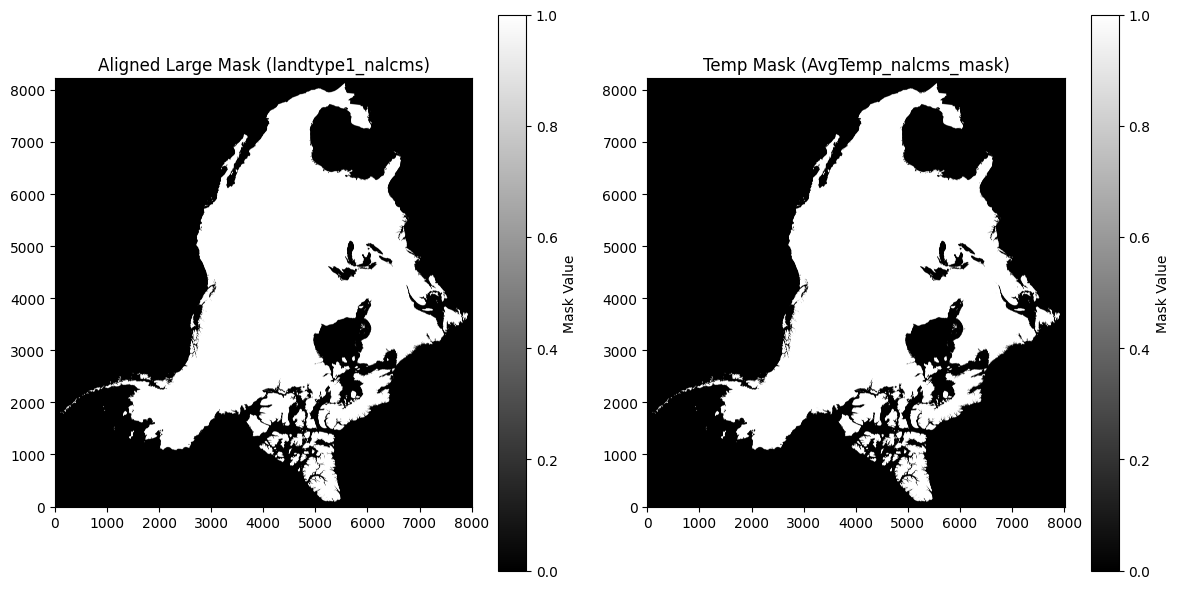

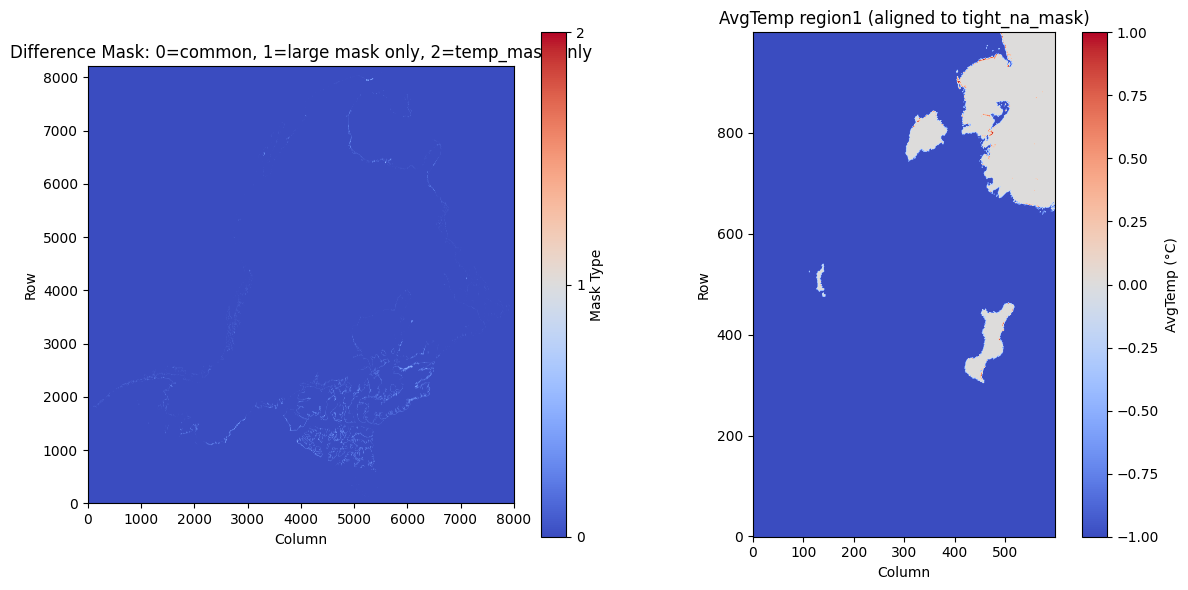

In [5]:
#create masks from the aligned_temp_to_large_nalcms_mask.nc and landtype1_nalcms_Temperate_needleleaf_in_daymet.nc
import numpy as np
from netCDF4 import Dataset
# Load the aligned temperature data     
with Dataset('aligned_temp_to_large_nalcms_mask.nc') as nc:
    aligned_temp = nc.variables['AvgTemp'][:]
    temp_mask = np.where(~np.isnan(aligned_temp), 1, 0)

# Load the large mask (landtype1_nalcms_Temperate_needleleaf_in_daymet.nc)
with Dataset('landtype1_nalcms_Temperate_needleleaf_in_daymet.nc') as nc:
    count = nc.variables['landtype_count'][:]
    large_mask = np.where(np.isnan(count), 0, 1)
    
# create a difference mask between aligned_large_mask and temp_mask
diff_mask = np.zeros_like(large_mask, dtype=np.int8) -1 
diff_mask[(large_mask == 1) & (temp_mask == 1)] = 0  # in both mask
diff_mask[(large_mask == 1) & (temp_mask != 1)] = 1  # in large mask only           
diff_mask[(temp_mask == 1) & (large_mask != 1)] = 2  # in temp_mask only

# Print unique values and counts for diff_mask
unique_diff_mask = np.unique(diff_mask)
print("Unique values in diff_mask:", unique_diff_mask)

# Print summary of the difference mask
unique, counts = np.unique(diff_mask, return_counts=True) 
for v, c in zip(unique, counts):
    if v == 0:
        print(f"Value: {v}, Count: {c}  (common )")
    elif v == 1:
        print(f"Value: {v}, Count: {c} (in large mask not in temp_mask)")
    elif v == 2:
        print(f"Value: {v}, Count: {c} (in temp_mask not in large mask)")

# Plot the aligned large mask and the temp_mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(large_mask, origin='lower', cmap='gray')
plt.title('Aligned Large Mask (landtype1_nalcms)')
plt.colorbar(label='Mask Value')
plt.subplot(1, 2, 2)        
plt.imshow(temp_mask, origin='lower', cmap='gray')
plt.title('Temp Mask (AvgTemp_nalcms_mask)')
plt.colorbar(label='Mask Value')
plt.tight_layout()
plt.show()


# Plot the difference mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(diff_mask==1, origin='lower', cmap='coolwarm', vmin=0, vmax=2)
plt.title('Difference Mask: 0=common, 1=large mask only, 2=temp_mask only')
plt.colorbar(ticks=[0, 1, 2], label='Mask Type')
plt.xlabel('Column')            
plt.ylabel('Row')


region1 = diff_mask[1000:2000, 1000:1600]
plt.subplot(1, 2, 2)
plt.imshow(region1, origin='lower', cmap='coolwarm')
plt.colorbar(label='AvgTemp (°C)')
plt.title('AvgTemp region1 (aligned to tight_na_mask)')
plt.xlabel('Column')
plt.ylabel('Row')




plt.tight_layout()
plt.show()

In [6]:
#create masks from the aligned_temp_to_large_nalcms_mask.nc and landtype1_nalcms_Temperate_needleleaf_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

# Load the averaged temperature data     
with Dataset('aligned_temp_to_large_nalcms_mask.nc') as nc:
    avg_temp = nc.variables['AvgTemp'][:]

# Load the large mask (landtype1_nalcms_Temperate_needleleaf_in_daymet.nc)
with Dataset('landtype1_nalcms_Temperate_needleleaf_in_daymet.nc') as nc:
    count = nc.variables['landtype_count'][:]

upper_bound = -2  # Define the upper bound for PFT2
lower_bound = -19 # Define the lower bound for PFT1

# Only consider cells with count >= 0 and valid temperature
valid = (~np.isnan(avg_temp)) & (count >= 0)

# Initialize output arrays
pft1 = np.zeros_like(count, dtype=int)
pft2 = np.zeros_like(count, dtype=int)

# Masks for each region
mask1 = valid & (avg_temp <= lower_bound)
mask2 = valid & (avg_temp > upper_bound)
mask_between = valid & (avg_temp > lower_bound) & (avg_temp <= upper_bound)

# Assign values
pft1[mask1] = count[mask1]
pft2[mask2] = count[mask2]
# For the in-between region, use vectorized calculation
frac = (avg_temp[mask_between] - lower_bound) / (upper_bound - lower_bound)
pft2[mask_between] = (count[mask_between] * frac).astype(int)
pft1[mask_between] = count[mask_between] - pft2[mask_between]

# save the pft1 and pft2 as a new NetCDF file
with Dataset('pft1-2_landtype1_nalcms_Temperate_needleleaf.nc', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft1.shape[0])
    dst.createDimension('x', pft1.shape[1])
    pft1_var = dst.createVariable('pft1_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft1_var[:, :] = pft1
    pft1_var.long_name = "PFT 1 count based on AvgTemp"
    pft1_var.units = "count"
    pft2_var = dst.createVariable('pft2_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft2_var[:, :] = pft2
    pft2_var.long_name = "PFT 2 count based on AvgTemp"
    pft2_var.units = "count"
    avg_temp_var = dst.createVariable('AvgTemp', 'f4', ('y', 'x'), fill_value=np.nan, zlib=True, complevel=5)
    avg_temp_var[:, :] = avg_temp
    avg_temp_var.long_name = "Average temperature of coldest month (aligned to large mask)"
    avg_temp_var.units = "C"    
    # add a global attribute for the temperature bounds
    dst.setncattr('temperature_bounds', f'PFT 1: <= {lower_bound} C, PFT 2: > {upper_bound} C')
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', 'landtype1_nalcms_Temperate_needleleaf_in_daymet.nc')

print("Saved PFT counts as pft1-2_daymet.nc")


/Users/7xw/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:489: RuntimeWarning: invalid value encountered in cast
  fill_value = np.asarray(fill_value, dtype=ndtype)


Saved PFT counts as pft1-2_daymet.nc


In [ ]:
#create pft2 from the aligned_temp_to_large_nalcms_mask.nc and landtype2_nalcms_Taiga_needleleaf_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

# Load the large mask (landtype2_nalcms_Taiga_needleleaf_in_daymet.nc)
with Dataset('../landtypes_count/landtype2_nalcms_Taiga_needleleaf_in_daymet.nc') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to pft2
pft2 = np.zeros_like(count, dtype=int)

# save the pft2 as a new NetCDF file
with Dataset('pft2_landtype2_nalcms_Taiga_needleleaf.nc', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft2.shape[0])
    dst.createDimension('x', pft2.shape[1])
    pft2_var = dst.createVariable('pft2_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft2_var[:, :] = count
    pft2_var.long_name = "PFT 2 count based on NALCMS_Taiga_needleleaf"
    pft2_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', 'landtype1_nalcms_Temperate_needleleaf_in_daymet.nc')

print("Saved PFT counts as pft2_nalcms2_daymet.nc")

In [ ]:
#create pft4 from landtype3_nalcms_Tropical_evergreen_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype3_nalcms_Tropical_evergreen_in_daymet.nc'
elm_pft = 'pft4'  # Define the PFT name for this landtype
# Load the large mask (landtype3_nalcms_Tropical_evergreen_in_daymet.nc)
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to elm_pft 
pft = np.zeros_like(count, dtype=int)

# save the pft4 as a new NetCDF file
with Dataset(f'{elmpft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft.shape[0])
    dst.createDimension('x', pft.shape[1])
    pft_var = dst.createVariable(f'{elm_pft}_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft_var[:, :] = count
    pft_var.long_name = f'{elm_pft} count based on {input_file}'
    pft_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")

In [ ]:
#create pft6 from landtype4_nalcms_Tropical_deciduous_in_daymet.nc
import numpy as np
from netCDF4 import Dataset

input_file = 'landtype4_nalcms_Tropical_deciduous_in_daymet.nc'
elm_pft = 'pft6'  # Define the PFT name for this landtype
# Load the large mask (landtype3_nalcms_Tropical_evergreen_in_daymet.nc)
with Dataset(f'../landtypes_count/{input_file}') as nc:
    count = nc.variables['landtype_count'][:]

# assign all the count to elm_pft 
pft = np.zeros_like(count, dtype=int)

# save the pft4 as a new NetCDF file
with Dataset(f'{elmpft}_{input_file}', 'w', format='NETCDF4') as dst:
    dst.createDimension('y', pft.shape[0])
    dst.createDimension('x', pft.shape[1])
    pft_var = dst.createVariable(f'{elm_pft}_count', 'i4', ('y', 'x'), zlib=True, complevel=5)
    pft_var[:, :] = count
    pft_var.long_name = f'{elm_pft} count based on {input_file}'
    pft_var.units = "count"
    # add a global attribute for the original landtype file
    dst.setncattr('original_landtype_file', input_file)

print(f"Saved PFT counts as {elm_pft}_{input_file}")